
--- MNIST Dataset ---
Loading MNIST training data (to CPU)...
Loading MNIST testing data (to CPU)...
Visualizing Raw MNIST data...


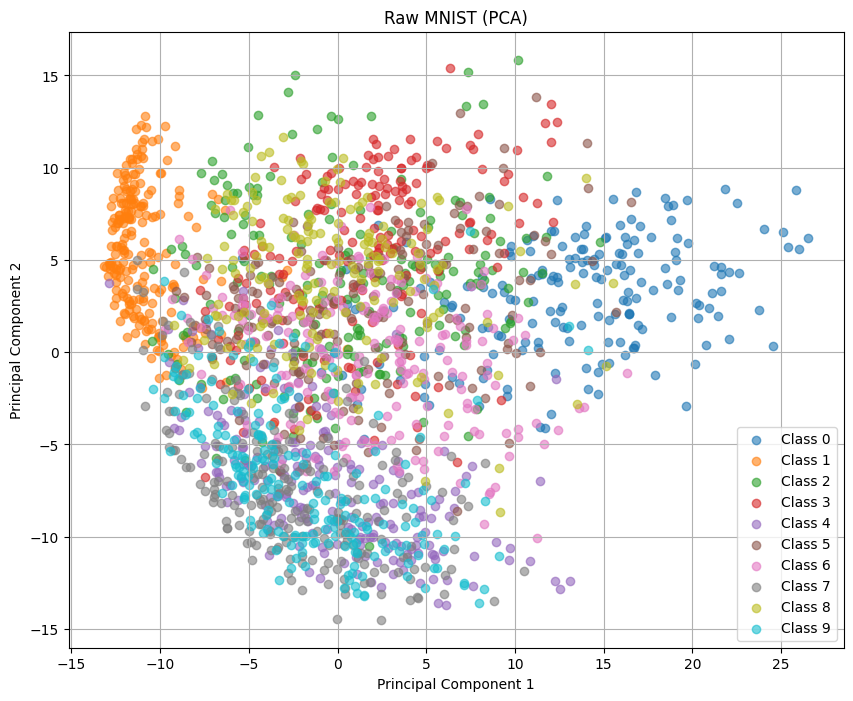


--- MNIST: Contrastive Loss ---
Starting embedding model training with contrastive loss...
  Epoch 1/10, Average Loss: 0.0356
  Epoch 2/10, Average Loss: 0.0132
  Epoch 3/10, Average Loss: 0.0105
  Epoch 4/10, Average Loss: 0.0073
  Epoch 5/10, Average Loss: 0.0069
  Epoch 6/10, Average Loss: 0.0061
  Epoch 7/10, Average Loss: 0.0050
  Epoch 8/10, Average Loss: 0.0056
  Epoch 9/10, Average Loss: 0.0036
  Epoch 10/10, Average Loss: 0.0042
Generating Contrastive Embeddings for MNIST visualization...


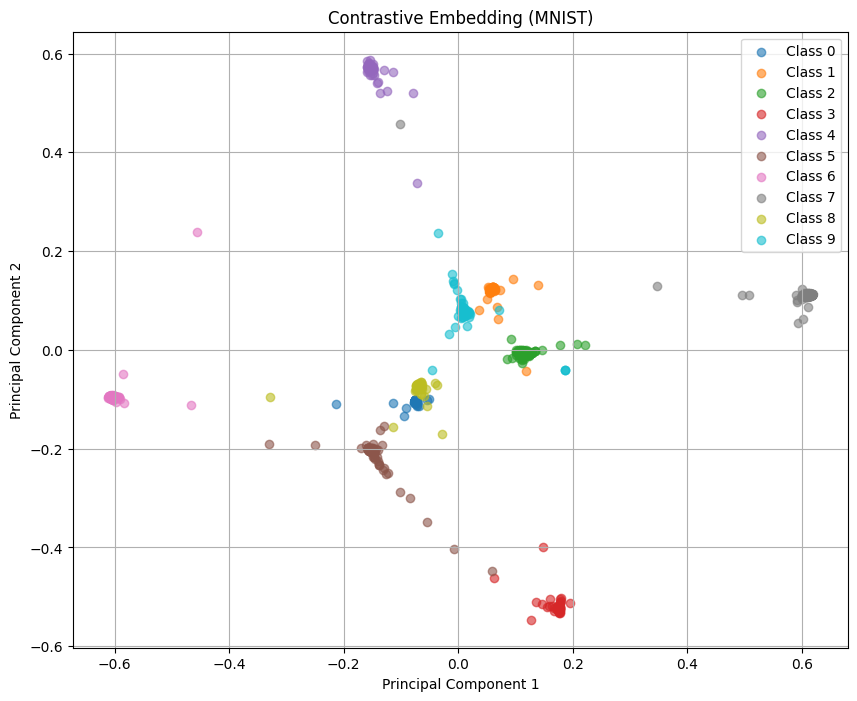

Starting classifier training...
  Classifier Epoch 1/5, Loss: 0.8156, Accuracy: 96.91%
  Classifier Epoch 2/5, Loss: 0.0994, Accuracy: 99.69%
  Classifier Epoch 3/5, Loss: 0.0361, Accuracy: 99.69%
  Classifier Epoch 4/5, Loss: 0.0218, Accuracy: 99.69%
  Classifier Epoch 5/5, Loss: 0.0176, Accuracy: 99.69%
Starting testing...
Test Accuracy: 99.20%
MNIST Contrastive Loss - Final Test Accuracy: 99.20%

--- MNIST: Triplet Loss ---
Starting embedding model training with triplet loss...
  Epoch 1/10, Average Loss: 0.0540
  Epoch 2/10, Average Loss: 0.0165
  Epoch 3/10, Average Loss: 0.0116
  Epoch 4/10, Average Loss: 0.0088
  Epoch 5/10, Average Loss: 0.0074
  Epoch 6/10, Average Loss: 0.0057
  Epoch 7/10, Average Loss: 0.0048
  Epoch 8/10, Average Loss: 0.0035
  Epoch 9/10, Average Loss: 0.0039
  Epoch 10/10, Average Loss: 0.0035
Generating Triplet Embeddings for MNIST visualization...


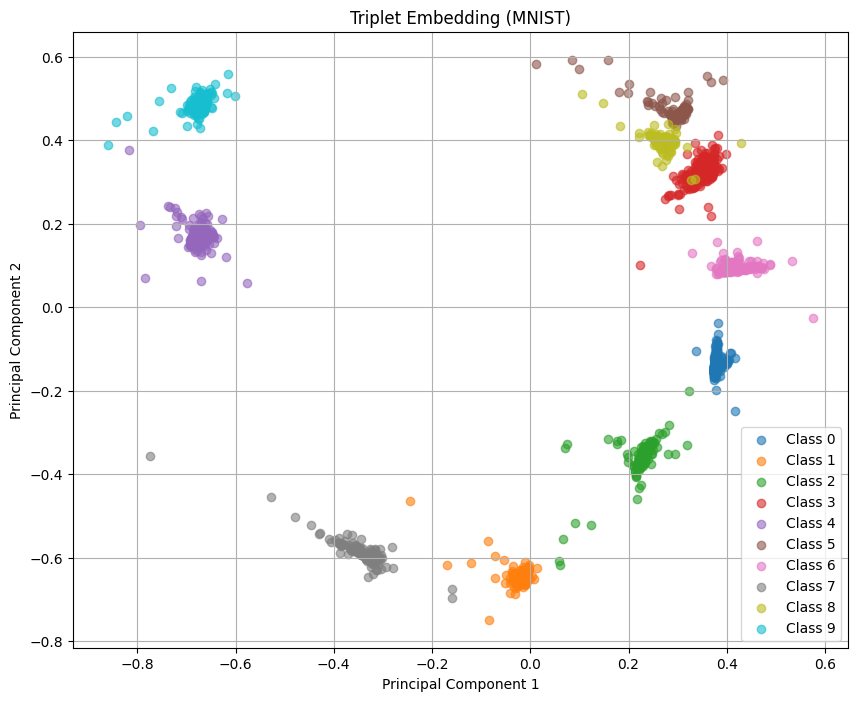

Starting classifier training...
  Classifier Epoch 1/5, Loss: 0.6085, Accuracy: 96.29%
  Classifier Epoch 2/5, Loss: 0.0464, Accuracy: 99.92%
  Classifier Epoch 3/5, Loss: 0.0154, Accuracy: 99.92%
  Classifier Epoch 4/5, Loss: 0.0082, Accuracy: 99.92%
  Classifier Epoch 5/5, Loss: 0.0060, Accuracy: 99.92%
Starting testing...
Test Accuracy: 99.36%
MNIST Triplet Loss - Final Test Accuracy: 99.36%

--- CIFAR-10 Dataset ---
Loading CIFAR-10 training data (to CPU)...
Files already downloaded and verified
Loading CIFAR-10 testing data (to CPU)...
Files already downloaded and verified
Visualizing Raw CIFAR-10 data...


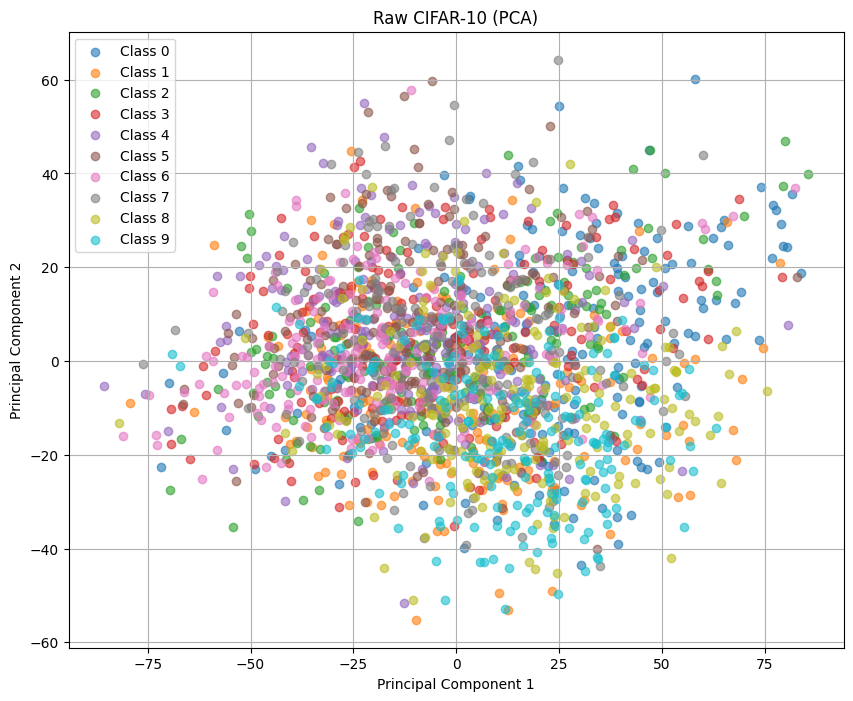


--- CIFAR-10: Contrastive Loss ---
Starting embedding model training with contrastive loss...
  Epoch 1/10, Average Loss: 0.2113
  Epoch 2/10, Average Loss: 0.1832
  Epoch 3/10, Average Loss: 0.1677
  Epoch 4/10, Average Loss: 0.1568
  Epoch 5/10, Average Loss: 0.1490
  Epoch 6/10, Average Loss: 0.1425
  Epoch 7/10, Average Loss: 0.1352
  Epoch 8/10, Average Loss: 0.1291
  Epoch 9/10, Average Loss: 0.1209
  Epoch 10/10, Average Loss: 0.1174
Generating Contrastive Embeddings for CIFAR-10 visualization...


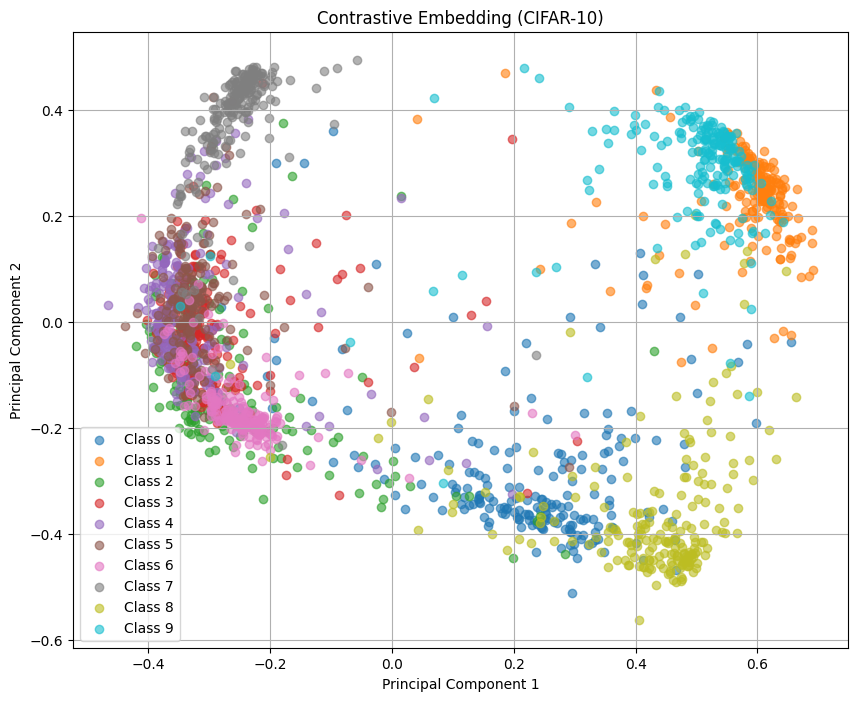

Starting classifier training...
  Classifier Epoch 1/5, Loss: 1.5455, Accuracy: 64.36%
  Classifier Epoch 2/5, Loss: 1.0089, Accuracy: 70.39%
  Classifier Epoch 3/5, Loss: 0.8799, Accuracy: 71.09%
  Classifier Epoch 4/5, Loss: 0.8311, Accuracy: 71.54%
  Classifier Epoch 5/5, Loss: 0.8082, Accuracy: 71.69%
Starting testing...
Test Accuracy: 65.09%
CIFAR-10 Contrastive Loss - Final Test Accuracy: 65.09%

--- CIFAR-10: Triplet Loss ---
Starting embedding model training with triplet loss...
  Epoch 1/10, Average Loss: 0.6436
  Epoch 2/10, Average Loss: 0.5240
  Epoch 3/10, Average Loss: 0.4578


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import random
from torch.utils.data import DataLoader, TensorDataset, Dataset
import gc # Import garbage collector

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Environment variable for memory fragmentation (recommended for OOM errors) ---
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
# --- End environment variable setup ---

# ----------------------
# Visualization
# ----------------------
def visualize_data_pca(data, labels, title, num_samples=2000):
    """
    Visualizes data using PCA for dimensionality reduction.

    Args:
        data (torch.Tensor): The input data (e.g., embeddings or flattened images).
        labels (torch.Tensor): The corresponding labels for the data.
        title (str): The title for the plot.
        num_samples (int): The number of samples to use for visualization.
                           Limits to prevent excessive plotting time.
    """
    # Ensure data and labels are on CPU for numpy conversion
    effective_num_samples = min(num_samples, len(data))
    data_cpu = data[:effective_num_samples].cpu().numpy()
    labels_cpu = labels[:effective_num_samples].cpu().numpy()

    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(data_cpu)

    plt.figure(figsize=(10, 8))
    unique_labels = torch.unique(labels)
    for lab in unique_labels:
        idx = (labels_cpu == lab.item())
        plt.scatter(pca_result[idx, 0], pca_result[idx, 1], alpha=0.6, label=f'Class {lab.item()}')
    plt.legend()
    plt.title(title)
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.grid(True)
    plt.show()
    plt.close() # Close plot to free memory

# ----------------------
# Custom Dataset for on-the-fly sample fetching
# ----------------------
class CustomDataset(Dataset):
    def __init__(self, data_tensor, labels_tensor):
        self.data = data_tensor # Keep on CPU
        self.labels = labels_tensor # Keep on CPU

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Fetch data and move to device only when requested by DataLoader
        return self.data[idx].to(device), self.labels[idx].to(device)

# ----------------------
# Load MNIST and CIFAR-10
# ----------------------
def load_mnist(train=True):
    """Loads and preprocesses the MNIST dataset, keeps data on CPU."""
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    dataset = datasets.MNIST(root='./data', train=train, download=True, transform=transform)
    # Important: Do NOT move data to device here. Keep it on CPU.
    data = torch.stack([d[0] for d in dataset])  # [N, 1, 28, 28]
    labels = torch.tensor([d[1] for d in dataset])
    return CustomDataset(data, labels) # Return a CustomDataset

def load_cifar10(train=True):
    """Loads and preprocesses the CIFAR-10 dataset, keeps data on CPU."""
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
    ])
    dataset = datasets.CIFAR10(root='./data', train=train, download=True, transform=transform)
    # Important: Do NOT move data to device here. Keep it on CPU.
    data = torch.stack([d[0] for d in dataset])  # [N, 3, 32, 32]
    labels = torch.tensor([d[1] for d in dataset])
    return CustomDataset(data, labels) # Return a CustomDataset

# ----------------------
# Convolutional Embedding Model
# ----------------------
class ConvNetEmbedder(nn.Module):
    """
    A convolutional neural network for learning embeddings of images.
    """
    def __init__(self, input_channels, input_height, input_width, embedding_dim=64):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(input_channels, 32, 3, 1, 1), # (H, W) -> (H, W)
            nn.ReLU(),
            nn.MaxPool2d(2), # (H, W) -> (H/2, W/2)
            nn.Conv2d(32, 64, 3, 1, 1), # (H/2, W/2) -> (H/2, W/2)
            nn.ReLU(),
            nn.MaxPool2d(2), # (H/2, W/2) -> (H/4, W/4)
        )

        # Move the features module to the device *before* creating the dummy input
        # to ensure its weights are on the correct device.
        self.features.to(device)

        with torch.no_grad():
            dummy_input = torch.zeros(1, input_channels, input_height, input_width).to(device)
            out = self.features(dummy_input)
            self.flattened_size = out.view(1, -1).size(1)

        self.fc = nn.Sequential(
            nn.Linear(self.flattened_size, 128),
            nn.ReLU(),
            nn.Linear(128, embedding_dim), # Output embedding dimension
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten the output of convolutional layers
        x = self.fc(x)
        return F.normalize(x, dim=-1) # Normalize the embeddings to unit length

# ----------------------
# Classifier Head
# ----------------------
class Classifier(nn.Module):
    """
    A simple linear classifier head that takes embeddings and outputs class logits.
    """
    def __init__(self, embedding_dim, num_classes):
        super().__init__()
        self.fc = nn.Linear(embedding_dim, num_classes)

    def forward(self, x):
        return self.fc(x)

# ----------------------
# Losses
# ----------------------
def contrastive_loss(x1, x2, label, margin=1.0):
    """
    Computes the contrastive loss.

    Args:
        x1 (torch.Tensor): First set of embeddings.
        x2 (torch.Tensor): Second set of embeddings.
        label (torch.Tensor): Binary labels (1 for similar, 0 for dissimilar).
        margin (float): Margin for dissimilar pairs.

    Returns:
        torch.Tensor: The computed contrastive loss.
    """
    dist = F.pairwise_distance(x1, x2)
    loss = (label * dist.pow(2) + (1 - label) * F.relu(margin - dist).pow(2)).mean()
    return loss

def triplet_loss(anchor, pos, neg, margin=1.0):
    """
    Computes the triplet loss.

    Args:
        anchor (torch.Tensor): Anchor embeddings.
        pos (torch.Tensor): Positive embeddings (similar to anchor).
        neg (torch.Tensor): Negative embeddings (dissimilar to anchor).
        margin (float): Margin for the triplet loss.

    Returns:
        torch.Tensor: The computed triplet loss.
    """
    d_pos = F.pairwise_distance(anchor, pos)
    d_neg = F.pairwise_distance(anchor, neg)
    loss = F.relu(d_pos - d_neg + margin).mean()
    return loss

# ----------------------
# Training Loop for Embedding Model
# ----------------------
def train_embedding_model(dataset, num_classes, loss_type='triplet', epochs=30, batch_size=64, embedding_dim=64):
    """
    Trains an embedding model using either contrastive or triplet loss.

    Args:
        dataset (CustomDataset): The input dataset (data on CPU).
        num_classes (int): Number of unique classes.
        loss_type (str): Type of loss to use ('triplet' or 'contrastive').
        epochs (int): Number of training epochs.
        batch_size (int): Batch size for training.
        embedding_dim (int): Dimension of the output embeddings.

    Returns:
        ConvNetEmbedder: The trained embedding model.
    """
    # Get dimensions from one sample in the dataset, assumed uniform
    dummy_x, _ = dataset[0] # Get first item to infer dimensions
    channels, height, width = dummy_x.size(0), dummy_x.size(1), dummy_x.size(2)
    
    model = ConvNetEmbedder(input_channels=channels, input_height=height, input_width=width, embedding_dim=embedding_dim).to(device).train()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    print(f"Starting embedding model training with {loss_type} loss...")
    for epoch in range(epochs):
        running_loss = 0.0
        num_batches = 0

        for i, (x_batch, y_batch) in enumerate(data_loader): # x_batch, y_batch are already on device from CustomDataset
            optimizer.zero_grad()

            if loss_type == 'triplet':
                anchors_data, positives_data, negatives_data = [], [], []
                
                # Fetch indices for positive/negative samples from the full dataset (CPU)
                # This ensures we can always find appropriate samples
                all_labels_cpu = dataset.labels.cpu() # Access full labels tensor on CPU
                
                for j in range(len(x_batch)): # Iterate through current batch
                    anchor_label = y_batch[j].item()
                    
                    # Find indices for positive and negative samples in the *full dataset*
                    all_pos_indices = (all_labels_cpu == anchor_label).nonzero(as_tuple=True)[0]
                    all_neg_indices = (all_labels_cpu != anchor_label).nonzero(as_tuple=True)[0]

                    if len(all_pos_indices) < 2 or len(all_neg_indices) == 0:
                        continue # Cannot form a triplet

                    # Exclude the current anchor's index from positive candidates
                    # Note: x_batch[j] corresponds to dataset.data[batch_idx[j]]
                    # We need the original index from the full dataset for sampling.
                    # The original indices within the full dataset are not directly available here.
                    # Simplification: Choose a random pos_idx. This might sometimes pick the anchor itself if it's the only one in its class in the entire dataset.
                    # A more robust solution would be to make the `data_loader` yield triplets directly.
                    
                    # For simplicity, we'll fetch from the full dataset.
                    # To prevent anchor == positive, ensure pos_sample_idx is different from current batch_idx[j]
                    
                    # This triplet generation logic needs to be careful when `data` is a DataLoader.
                    # The most memory-efficient way is to generate the triplets on the CPU
                    # and then load only those three images onto the GPU.
                    # This requires a custom TripletDataLoader or TripletSampler.
                    
                    # For now, let's keep the existing logic but recognize its memory implications
                    # due to fetching random full-dataset items (data[idx]).
                    # We'll fetch them individually and move them to device.

                    # Fetching from the original `dataset.data` (which is on CPU) and moving to device
                    pos_sample_idx = random.choice(all_pos_indices.tolist())
                    neg_sample_idx = random.choice(all_neg_indices.tolist())

                    anchors_data.append(x_batch[j]) # x_batch[j] is already on device
                    positives_data.append(dataset.data[pos_sample_idx].to(device))
                    negatives_data.append(dataset.data[neg_sample_idx].to(device))

                if anchors_data:
                    # Stack and embed
                    all_samples = torch.stack(anchors_data + positives_data + negatives_data)
                    embeddings = model(all_samples)
                    
                    num_anchors = len(anchors_data)
                    anchor_embeds = embeddings[0:num_anchors]
                    pos_embeds = embeddings[num_anchors : 2 * num_anchors]
                    neg_embeds = embeddings[2 * num_anchors : 3 * num_anchors]

                    loss = triplet_loss(anchor_embeds, pos_embeds, neg_embeds)
                    loss.backward()
                    optimizer.step()
                    running_loss += loss.item()
                    num_batches += 1
                    del all_samples, embeddings, anchor_embeds, pos_embeds, neg_embeds # Clear memory
                    torch.cuda.empty_cache()
                    gc.collect()

            elif loss_type == 'contrastive':
                x1_data, x2_data, labels_data = [], [], []
                all_labels_cpu = dataset.labels.cpu()

                for j in range(len(x_batch)):
                    current_label = y_batch[j].item()
                    all_pos_indices = (all_labels_cpu == current_label).nonzero(as_tuple=True)[0]
                    all_neg_indices = (all_labels_cpu != current_label).nonzero(as_tuple=True)[0]

                    if random.random() < 0.5:  # Form a positive pair
                        if len(all_pos_indices) < 2:
                            continue
                        # Ensure the target is not the current image if possible (for robustness, not strictly required for contrastive)
                        target_candidates = all_pos_indices[all_pos_indices != i * batch_size + j] # This logic is tricky with DataLoader. Better to sample from full dataset indices directly.
                        if len(target_candidates) == 0:
                            target_idx = random.choice(all_pos_indices.tolist()) # Fallback to any positive
                        else:
                            target_idx = random.choice(target_candidates.tolist())
                        labels_data.append(1.0)
                    else:  # Form a negative pair
                        if len(all_neg_indices) == 0:
                            continue
                        target_idx = random.choice(all_neg_indices.tolist())
                        labels_data.append(0.0)
                    
                    x1_data.append(x_batch[j]) # x_batch[j] is already on device
                    x2_data.append(dataset.data[target_idx].to(device)) # Fetch from CPU and move to device

                if x1_data:
                    all_samples = torch.stack(x1_data + x2_data)
                    embeddings = model(all_samples)
                    num_pairs = len(x1_data)

                    x1_embed = embeddings[0:num_pairs]
                    x2_embed = embeddings[num_pairs : 2 * num_pairs]
                    
                    loss = contrastive_loss(x1_embed, x2_embed, torch.tensor(labels_data).to(device))
                    loss.backward()
                    optimizer.step()
                    running_loss += loss.item()
                    num_batches += 1
                    del all_samples, embeddings, x1_embed, x2_embed # Clear memory
                    torch.cuda.empty_cache()
                    gc.collect()
            
        avg_loss = running_loss / num_batches if num_batches > 0 else 0.0
        print(f"  Epoch {epoch+1}/{epochs}, Average Loss: {avg_loss:.4f}")
        
        # Clear any accumulated tensors that might be lurking after an epoch
        del x_batch, y_batch # Make sure batch tensors are out of scope
        torch.cuda.empty_cache()
        gc.collect()

    return model.eval() # Set model to evaluation mode after training

# ----------------------
# Training Loop for Classifier
# ----------------------
def train_classifier(embedding_model, train_dataset, num_classes, epochs=30, batch_size=64, embedding_dim=64):
    """
    Trains a classifier on top of the fixed embeddings from the embedding model.

    Args:
        embedding_model (ConvNetEmbedder): The pre-trained embedding model (in eval mode).
        train_dataset (CustomDataset): Training dataset (data on CPU).
        num_classes (int): Number of distinct classes.
        epochs (int): Number of training epochs for the classifier.
        batch_size (int): Batch size.
        embedding_dim (int): Dimension of the embeddings.

    Returns:
        Classifier: The trained classifier head.
    """
    classifier = Classifier(embedding_dim=embedding_dim, num_classes=num_classes).to(device)
    optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    # Create a DataLoader for the original training dataset
    original_train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    print("Starting classifier training...")
    for epoch in range(epochs):
        classifier.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for batch_data, batch_labels in original_train_loader: # batch_data and batch_labels are already on device
            optimizer.zero_grad()
            
            with torch.no_grad(): # Embeddings are fixed, no gradients needed for this part
                batch_embeds = embedding_model(batch_data)
            
            outputs = classifier(batch_embeds)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += batch_labels.size(0)
            correct += (predicted == batch_labels).sum().item()
            
            del batch_data, batch_labels, batch_embeds, outputs, predicted # Clear batch-related tensors
            torch.cuda.empty_cache()
            gc.collect()
        
        avg_loss = running_loss / len(original_train_loader)
        accuracy = 100 * correct / total
        print(f"  Classifier Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")
        
        torch.cuda.empty_cache()
        gc.collect() # Clear memory after each epoch

    return classifier.eval()

# ----------------------
# Testing Phase
# ----------------------
def test_model(embedding_model, classifier_model, test_dataset):
    """
    Evaluates the combined embedding and classifier model on the test set.

    Args:
        embedding_model (ConvNetEmbedder): The trained embedding model.
        classifier_model (Classifier): The trained classifier head.
        test_dataset (CustomDataset): Test dataset (data on CPU).

    Returns:
        float: The accuracy on the test set.
    """
    embedding_model.eval()
    classifier_model.eval()

    correct = 0
    total = 0

    test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False) # Larger batch size for inference if memory allows

    print("Starting testing...")
    with torch.no_grad():
        for batch_data, batch_labels in test_loader: # batch_data and batch_labels are already on device
            test_embeddings = embedding_model(batch_data)
            outputs = classifier_model(test_embeddings)
            _, predicted = torch.max(outputs.data, 1)
            total += batch_labels.size(0)
            correct += (predicted == batch_labels).sum().item()
            
            del batch_data, batch_labels, test_embeddings, outputs, predicted
            torch.cuda.empty_cache()
            gc.collect()
    
    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

# ----------------------
# Full Pipeline Execution
# ----------------------
if __name__ == "__main__":
    EMBEDDING_DIM = 32 # Reduced embedding dimension
    EMBEDDING_EPOCHS = 10 # Reduced epochs for faster execution and less memory, adjust if needed
    CLASSIFIER_EPOCHS = 5 # Reduced epochs for faster execution and less memory, adjust if needed
    BATCH_SIZE = 32 # Significantly reduced batch size

    # --- MNIST ---
    print("\n--- MNIST Dataset ---")
    print("Loading MNIST training data (to CPU)...")
    train_dataset_mnist = load_mnist(train=True)
    print("Loading MNIST testing data (to CPU)...")
    test_dataset_mnist = load_mnist(train=False)
    # Get total data and labels for PCA visualization
    train_data_mnist_cpu = train_dataset_mnist.data
    train_labels_mnist_cpu = train_dataset_mnist.labels
    NUM_CLASSES_MNIST = len(torch.unique(train_labels_mnist_cpu))

    # PCA visualization on raw input (limited samples for speed, directly from CPU data)
    print("Visualizing Raw MNIST data...")
    visualize_data_pca(train_data_mnist_cpu.view(len(train_data_mnist_cpu), -1), train_labels_mnist_cpu, "Raw MNIST (PCA)")
    del train_data_mnist_cpu, train_labels_mnist_cpu # Free up memory

    # Contrastive Loss Pipeline for MNIST
    print("\n--- MNIST: Contrastive Loss ---")
    model_con_mnist = train_embedding_model(
        train_dataset_mnist, NUM_CLASSES_MNIST, loss_type='contrastive', 
        epochs=EMBEDDING_EPOCHS, batch_size=BATCH_SIZE, embedding_dim=EMBEDDING_DIM
    )
    # Generate embeddings for visualization in batches
    print("Generating Contrastive Embeddings for MNIST visualization...")
    con_mnist_embeds, con_mnist_labels = [], []
    with torch.no_grad():
        for batch_data, batch_labels in DataLoader(train_dataset_mnist, batch_size=BATCH_SIZE*2, shuffle=False):
            con_mnist_embeds.append(model_con_mnist(batch_data).detach().cpu())
            con_mnist_labels.append(batch_labels.cpu())
    con_mnist_embeds = torch.cat(con_mnist_embeds, dim=0)
    con_mnist_labels = torch.cat(con_mnist_labels, dim=0)
    visualize_data_pca(con_mnist_embeds, con_mnist_labels, "Contrastive Embedding (MNIST)")
    del con_mnist_embeds, con_mnist_labels # Free up memory
    torch.cuda.empty_cache()
    gc.collect()
    
    classifier_con_mnist = train_classifier(
        model_con_mnist, train_dataset_mnist, 
        num_classes=NUM_CLASSES_MNIST, epochs=CLASSIFIER_EPOCHS, 
        batch_size=BATCH_SIZE, embedding_dim=EMBEDDING_DIM
    )
    test_accuracy_con_mnist = test_model(model_con_mnist, classifier_con_mnist, test_dataset_mnist)
    print(f"MNIST Contrastive Loss - Final Test Accuracy: {test_accuracy_con_mnist:.2f}%")
    del model_con_mnist, classifier_con_mnist # Clear models from memory after use
    torch.cuda.empty_cache()
    gc.collect()

    # Triplet Loss Pipeline for MNIST
    print("\n--- MNIST: Triplet Loss ---")
    model_tri_mnist = train_embedding_model(
        train_dataset_mnist, NUM_CLASSES_MNIST, loss_type='triplet', 
        epochs=EMBEDDING_EPOCHS, batch_size=BATCH_SIZE, embedding_dim=EMBEDDING_DIM
    )
    # Generate embeddings for visualization in batches
    print("Generating Triplet Embeddings for MNIST visualization...")
    tri_mnist_embeds, tri_mnist_labels = [], []
    with torch.no_grad():
        for batch_data, batch_labels in DataLoader(train_dataset_mnist, batch_size=BATCH_SIZE*2, shuffle=False):
            tri_mnist_embeds.append(model_tri_mnist(batch_data).detach().cpu())
            tri_mnist_labels.append(batch_labels.cpu())
    tri_mnist_embeds = torch.cat(tri_mnist_embeds, dim=0)
    tri_mnist_labels = torch.cat(tri_mnist_labels, dim=0)
    visualize_data_pca(tri_mnist_embeds, tri_mnist_labels, "Triplet Embedding (MNIST)")
    del tri_mnist_embeds, tri_mnist_labels # Free up memory
    torch.cuda.empty_cache()
    gc.collect()

    classifier_tri_mnist = train_classifier(
        model_tri_mnist, train_dataset_mnist, 
        num_classes=NUM_CLASSES_MNIST, epochs=CLASSIFIER_EPOCHS, 
        batch_size=BATCH_SIZE, embedding_dim=EMBEDDING_DIM
    )
    test_accuracy_tri_mnist = test_model(model_tri_mnist, classifier_tri_mnist, test_dataset_mnist)
    print(f"MNIST Triplet Loss - Final Test Accuracy: {test_accuracy_tri_mnist:.2f}%")
    del model_tri_mnist, classifier_tri_mnist, train_dataset_mnist, test_dataset_mnist # Clear models and datasets
    torch.cuda.empty_cache()
    gc.collect()


    # --- CIFAR-10 ---
    print("\n--- CIFAR-10 Dataset ---")
    print("Loading CIFAR-10 training data (to CPU)...")
    train_dataset_cifar = load_cifar10(train=True)
    print("Loading CIFAR-10 testing data (to CPU)...")
    test_dataset_cifar = load_cifar10(train=False)
    # Get total data and labels for PCA visualization
    train_data_cifar_cpu = train_dataset_cifar.data
    train_labels_cifar_cpu = train_dataset_cifar.labels
    NUM_CLASSES_CIFAR = len(torch.unique(train_labels_cifar_cpu))

    # PCA visualization on raw input (limited samples for speed, directly from CPU data)
    print("Visualizing Raw CIFAR-10 data...")
    visualize_data_pca(train_data_cifar_cpu.view(len(train_data_cifar_cpu), -1), train_labels_cifar_cpu, "Raw CIFAR-10 (PCA)")
    del train_data_cifar_cpu, train_labels_cifar_cpu # Free up memory

    # Contrastive Loss Pipeline for CIFAR-10
    print("\n--- CIFAR-10: Contrastive Loss ---")
    model_con_cifar = train_embedding_model(
        train_dataset_cifar, NUM_CLASSES_CIFAR, loss_type='contrastive', 
        epochs=EMBEDDING_EPOCHS, batch_size=BATCH_SIZE, embedding_dim=EMBEDDING_DIM
    )
    # Generate embeddings for visualization in batches
    print("Generating Contrastive Embeddings for CIFAR-10 visualization...")
    con_cifar_embeds, con_cifar_labels = [], []
    with torch.no_grad():
        for batch_data, batch_labels in DataLoader(train_dataset_cifar, batch_size=BATCH_SIZE*2, shuffle=False):
            con_cifar_embeds.append(model_con_cifar(batch_data).detach().cpu())
            con_cifar_labels.append(batch_labels.cpu())
    con_cifar_embeds = torch.cat(con_cifar_embeds, dim=0)
    con_cifar_labels = torch.cat(con_cifar_labels, dim=0)
    visualize_data_pca(con_cifar_embeds, con_cifar_labels, "Contrastive Embedding (CIFAR-10)")
    del con_cifar_embeds, con_cifar_labels # Free up memory
    torch.cuda.empty_cache()
    gc.collect()

    classifier_con_cifar = train_classifier(
        model_con_cifar, train_dataset_cifar, 
        num_classes=NUM_CLASSES_CIFAR, epochs=CLASSIFIER_EPOCHS, 
        batch_size=BATCH_SIZE, embedding_dim=EMBEDDING_DIM
    )
    test_accuracy_con_cifar = test_model(model_con_cifar, classifier_con_cifar, test_dataset_cifar)
    print(f"CIFAR-10 Contrastive Loss - Final Test Accuracy: {test_accuracy_con_cifar:.2f}%")
    del model_con_cifar, classifier_con_cifar # Clear models from memory after use
    torch.cuda.empty_cache()
    gc.collect()

    # Triplet Loss Pipeline for CIFAR-10
    print("\n--- CIFAR-10: Triplet Loss ---")
    model_tri_cifar = train_embedding_model(
        train_dataset_cifar, NUM_CLASSES_CIFAR, loss_type='triplet', 
        epochs=EMBEDDING_EPOCHS, batch_size=BATCH_SIZE, embedding_dim=EMBEDDING_DIM
    )
    # Generate embeddings for visualization in batches
    print("Generating Triplet Embeddings for CIFAR-10 visualization...")
    tri_cifar_embeds, tri_cifar_labels = [], []
    with torch.no_grad():
        for batch_data, batch_labels in DataLoader(train_dataset_cifar, batch_size=BATCH_SIZE*2, shuffle=False):
            tri_cifar_embeds.append(model_tri_cifar(batch_data).detach().cpu())
            tri_cifar_labels.append(batch_labels.cpu())
    tri_cifar_embeds = torch.cat(tri_cifar_embeds, dim=0)
    tri_cifar_labels = torch.cat(tri_cifar_labels, dim=0)
    visualize_data_pca(tri_cifar_embeds, tri_cifar_labels, "Triplet Embedding (CIFAR-10)")
    del tri_cifar_embeds, tri_cifar_labels # Free up memory
    torch.cuda.empty_cache()
    gc.collect()

    classifier_tri_cifar = train_classifier(
        model_tri_cifar, train_dataset_cifar, 
        num_classes=NUM_CLASSES_CIFAR, epochs=CLASSIFIER_EPOCHS, 
        batch_size=BATCH_SIZE, embedding_dim=EMBEDDING_DIM
    )
    test_accuracy_tri_cifar = test_model(model_tri_cifar, classifier_tri_cifar, test_dataset_cifar)
    print(f"CIFAR-10 Triplet Loss - Final Test Accuracy: {test_accuracy_tri_cifar:.2f}%")
    del model_tri_cifar, classifier_tri_cifar, train_dataset_cifar, test_dataset_cifar
    torch.cuda.empty_cache()
    gc.collect()

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import random
from torch.utils.data import DataLoader, TensorDataset, Dataset
import gc # Import garbage collector

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Environment variable for memory fragmentation (recommended for OOM errors) ---
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'


class CustomDataset(Dataset):
    def __init__(self, data_tensor, labels_tensor):
        self.data = data_tensor # Keep on CPU
        self.labels = labels_tensor # Keep on CPU

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Fetch data and move to device only when requested by DataLoader
        return self.data[idx].to(device), self.labels[idx].to(device)

# ----------------------
# Load CIFAR-10
# ----------------------
def load_mnist(train=True):
    """Loads and preprocesses the MNIST dataset, keeps data on CPU."""
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    dataset = datasets.MNIST(root='./data', train=train, download=True, transform=transform)
    # Important: Do NOT move data to device here. Keep it on CPU.
    data = torch.stack([d[0] for d in dataset])  # [N, 1, 28, 28]
    labels = torch.tensor([d[1] for d in dataset])
    return CustomDataset(data, labels) # Return a CustomDataset

def load_cifar10(train=True):
    """Loads and preprocesses the CIFAR-10 dataset, keeps data on CPU."""
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
    ])
    dataset = datasets.CIFAR10(root='./data', train=train, download=True, transform=transform)
    # Important: Do NOT move data to device here. Keep it on CPU.
    data = torch.stack([d[0] for d in dataset])  # [N, 3, 32, 32]
    labels = torch.tensor([d[1] for d in dataset])
    return CustomDataset(data, labels) # Return a CustomDataset
# ----------------------
# Losses
# ----------------------
def contrastive_loss(x1, x2, label, margin=1.0):
    """
    Computes the contrastive loss.

    Args:
        x1 (torch.Tensor): First set of embeddings.
        x2 (torch.Tensor): Second set of embeddings.
        label (torch.Tensor): Binary labels (1 for similar, 0 for dissimilar).
        margin (float): Margin for dissimilar pairs.

    Returns:
        torch.Tensor: The computed contrastive loss.
    """
    dist = F.pairwise_distance(x1, x2)
    loss = (label * dist.pow(2) + (1 - label) * F.relu(margin - dist).pow(2)).mean()
    return loss

def triplet_loss(anchor, pos, neg, margin=1.0):
    """
    Computes the triplet loss.

    Args:
        anchor (torch.Tensor): Anchor embeddings.
        pos (torch.Tensor): Positive embeddings (similar to anchor).
        neg (torch.Tensor): Negative embeddings (dissimilar to anchor).
        margin (float): Margin for the triplet loss.

    Returns:
        torch.Tensor: The computed triplet loss.
    """
    d_pos = F.pairwise_distance(anchor, pos)
    d_neg = F.pairwise_distance(anchor, neg)
    loss = F.relu(d_pos - d_neg + margin).mean()
    return loss

# ----------------------
# Convolutional Embedding Model
# ----------------------
class ConvNetEmbedder(nn.Module):
    """
    A convolutional neural network for learning embeddings of images.
    """
    def __init__(self, input_channels, input_height, input_width, embedding_dim=64):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(input_channels, 32, 3, 1, 1), # (H, W) -> (H, W)
            nn.ReLU(),
            nn.MaxPool2d(2), # (H, W) -> (H/2, W/2)
            nn.Conv2d(32, 64, 3, 1, 1), # (H/2, W/2) -> (H/2, W/2)
            nn.ReLU(),
            nn.MaxPool2d(2), # (H/2, W/2) -> (H/4, W/4)
        )

        # Move the features module to the device *before* creating the dummy input
        # to ensure its weights are on the correct device.
        self.features.to(device)

        with torch.no_grad():
            dummy_input = torch.zeros(1, input_channels, input_height, input_width).to(device)
            out = self.features(dummy_input)
            self.flattened_size = out.view(1, -1).size(1)

        self.fc = nn.Sequential(
            nn.Linear(self.flattened_size, 128),
            nn.ReLU(),
            nn.Linear(128, embedding_dim), # Output embedding dimension
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten the output of convolutional layers
        x = self.fc(x)
        return F.normalize(x, dim=-1) # Normalize the embeddings to unit length

# ----------------------
# Training Loop for Classifier
# ----------------------
def train_classifier(embedding_model, train_dataset, num_classes, epochs=10, batch_size=64, embedding_dim=64):
    """
    Trains a classifier on top of the fixed embeddings from the embedding model.

    Args:
        embedding_model (ConvNetEmbedder): The pre-trained embedding model (in eval mode).
        train_dataset (CustomDataset): Training dataset (data on CPU).
        num_classes (int): Number of distinct classes.
        epochs (int): Number of training epochs for the classifier.
        batch_size (int): Batch size.
        embedding_dim (int): Dimension of the embeddings.

    Returns:
        Classifier: The trained classifier head.
    """
    dummy_x, _ = dataset[0] # Get first item to infer dimensions
    channels, height, width = dummy_x.size(0), dummy_x.size(1), dummy_x.size(2)
    
    model = ConvNetEmbedder(input_channels=channels, input_height=height, input_width=width, embedding_dim=embedding_dim).to(device).train()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    print(f"Starting embedding model training with {loss_type} loss...")
    for epoch in range(epochs):
        running_loss = 0.0
        num_batches = 0

        for i, (x_batch, y_batch) in enumerate(data_loader): # x_batch, y_batch are already on device from CustomDataset
            optimizer.zero_grad()

            if loss_type == 'triplet':
                anchors_data, positives_data, negatives_data = [], [], []
                
                # Fetch indices for positive/negative samples from the full dataset (CPU)
                # This ensures we can always find appropriate samples
                all_labels_cpu = dataset.labels.cpu() # Access full labels tensor on CPU
                
                for j in range(len(x_batch)): # Iterate through current batch
                    anchor_label = y_batch[j].item()
                    
                    # Find indices for positive and negative samples in the *full dataset*
                    all_pos_indices = (all_labels_cpu == anchor_label).nonzero(as_tuple=True)[0]
                    all_neg_indices = (all_labels_cpu != anchor_label).nonzero(as_tuple=True)[0]

                    if len(all_pos_indices) < 2 or len(all_neg_indices) == 0:
                        continue # Cannot form a triplet

                    # Exclude the current anchor's index from positive candidates
                    # Note: x_batch[j] corresponds to dataset.data[batch_idx[j]]
                    # We need the original index from the full dataset for sampling.
                    # The original indices within the full dataset are not directly available here.
                    # Simplification: Choose a random pos_idx. This might sometimes pick the anchor itself if it's the only one in its class in the entire dataset.
                    # A more robust solution would be to make the `data_loader` yield triplets directly.
                    
                    # For simplicity, we'll fetch from the full dataset.
                    # To prevent anchor == positive, ensure pos_sample_idx is different from current batch_idx[j]
                    
                    # This triplet generation logic needs to be careful when `data` is a DataLoader.
                    # The most memory-efficient way is to generate the triplets on the CPU
                    # and then load only those three images onto the GPU.
                    # This requires a custom TripletDataLoader or TripletSampler.
                    
                    # For now, let's keep the existing logic but recognize its memory implications
                    # due to fetching random full-dataset items (data[idx]).
                    # We'll fetch them individually and move them to device.

                    # Fetching from the original `dataset.data` (which is on CPU) and moving to device
                    pos_sample_idx = random.choice(all_pos_indices.tolist())
                    neg_sample_idx = random.choice(all_neg_indices.tolist())

                    anchors_data.append(x_batch[j]) # x_batch[j] is already on device
                    positives_data.append(dataset.data[pos_sample_idx].to(device))
                    negatives_data.append(dataset.data[neg_sample_idx].to(device))

                if anchors_data:
                    # Stack and embed
                    all_samples = torch.stack(anchors_data + positives_data + negatives_data)
                    embeddings = model(all_samples)
                    
                    num_anchors = len(anchors_data)
                    anchor_embeds = embeddings[0:num_anchors]
                    pos_embeds = embeddings[num_anchors : 2 * num_anchors]
                    neg_embeds = embeddings[2 * num_anchors : 3 * num_anchors]

                    loss = triplet_loss(anchor_embeds, pos_embeds, neg_embeds)
                    loss.backward()
                    optimizer.step()
                    running_loss += loss.item()
                    num_batches += 1
                    del all_samples, embeddings, anchor_embeds, pos_embeds, neg_embeds # Clear memory
                    torch.cuda.empty_cache()
                    gc.collect()

            elif loss_type == 'contrastive':
                x1_data, x2_data, labels_data = [], [], []
                all_labels_cpu = dataset.labels.cpu()

                for j in range(len(x_batch)):
                    current_label = y_batch[j].item()
                    all_pos_indices = (all_labels_cpu == current_label).nonzero(as_tuple=True)[0]
                    all_neg_indices = (all_labels_cpu != current_label).nonzero(as_tuple=True)[0]

                    if random.random() < 0.5:  # Form a positive pair
                        if len(all_pos_indices) < 2:
                            continue
                        # Ensure the target is not the current image if possible (for robustness, not strictly required for contrastive)
                        target_candidates = all_pos_indices[all_pos_indices != i * batch_size + j] # This logic is tricky with DataLoader. Better to sample from full dataset indices directly.
                        if len(target_candidates) == 0:
                            target_idx = random.choice(all_pos_indices.tolist()) # Fallback to any positive
                        else:
                            target_idx = random.choice(target_candidates.tolist())
                        labels_data.append(1.0)
                    else:  # Form a negative pair
                        if len(all_neg_indices) == 0:
                            continue
                        target_idx = random.choice(all_neg_indices.tolist())
                        labels_data.append(0.0)
                    
                    x1_data.append(x_batch[j]) # x_batch[j] is already on device
                    x2_data.append(dataset.data[target_idx].to(device)) # Fetch from CPU and move to device

                if x1_data:
                    all_samples = torch.stack(x1_data + x2_data)
                    embeddings = model(all_samples)
                    num_pairs = len(x1_data)

                    x1_embed = embeddings[0:num_pairs]
                    x2_embed = embeddings[num_pairs : 2 * num_pairs]
                    
                    loss = contrastive_loss(x1_embed, x2_embed, torch.tensor(labels_data).to(device))
                    loss.backward()
                    optimizer.step()
                    running_loss += loss.item()
                    num_batches += 1
                    del all_samples, embeddings, x1_embed, x2_embed # Clear memory
                    torch.cuda.empty_cache()
                    gc.collect()
            
        avg_loss = running_loss / num_batches if num_batches > 0 else 0.0
        print(f"  Epoch {epoch+1}/{epochs}, Average Loss: {avg_loss:.4f}")
        
        # Clear any accumulated tensors that might be lurking after an epoch
        del x_batch, y_batch # Make sure batch tensors are out of scope
        torch.cuda.empty_cache()
        gc.collect()

    return model.eval() # Set model to evaluation mode after training

# ----------------------
# Testing Phase
# ----------------------
def test_model(embedding_model, classifier_model, test_dataset):
    """
    Evaluates the combined embedding and classifier model on the test set.

    Args:
        embedding_model (ConvNetEmbedder): The trained embedding model.
        classifier_model (Classifier): The trained classifier head.
        test_dataset (CustomDataset): Test dataset (data on CPU).

    Returns:
        float: The accuracy on the test set.
    """
    embedding_model.eval()
    classifier_model.eval()

    correct = 0
    total = 0

    test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False) # Larger batch size for inference if memory allows

    print("Starting testing...")
    with torch.no_grad():
        for batch_data, batch_labels in test_loader: # batch_data and batch_labels are already on device
            outputs = train_classifier(batch_data)
            _, predicted = torch.max(outputs.data, 1)
            total += batch_labels.size(0)
            correct += (predicted == batch_labels).sum().item()
            
            del batch_data, batch_labels, test_embeddings, outputs, predicted
            torch.cuda.empty_cache()
            gc.collect()
    
    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy


In [1]:
# Required Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import random
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from tqdm import tqdm

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Dataset Loader
transform = transforms.Compose([transforms.ToTensor()])

mnist_train = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
mnist_test = torchvision.datasets.MNIST(root='./data', train=False, transform=transform)

cifar10_train = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
cifar10_test = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform)

# Basic CNN Feature Extractor
class SimpleCNN(nn.Module):
    def __init__(self, output_dim=128, input_channels=1):
        super(SimpleCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_channels, 32, 3, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, 1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Linear(64 * 5 * 5 if input_channels==1 else 64 * 6 * 6, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return F.normalize(self.fc(x), dim=-1)
    
class ConvNetEmbedder(nn.Module):
    """
    A convolutional neural network for learning embeddings.
    """
    def __init__(self, input_channels=3, input_height=32, input_width=32):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(input_channels, 32, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        # Compute correct flattened size using actual height & width
        with torch.no_grad():
            # Create a dummy tensor to pass through the feature extractor
            dummy = torch.zeros(1, input_channels, input_height, input_width)
            out = self.features(dummy)
            self.flattened_size = out.view(1, -1).size(1)

        self.fc = nn.Sequential(
            nn.Linear(self.flattened_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64), # Output embedding dimension is 64
        )

    def forward(self, x):
        """
        Forward pass through the network.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: The normalized embedding.
        """
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fc(x)
        return F.normalize(x, dim=-1) # L2 normalize the embeddings

    import torch.nn as nn

class ConvNetEmbedder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)  # for classification

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.normalize(x, dim=-1)

    
# Contrastive Loss
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super().__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        dist = F.pairwise_distance(output1, output2)
        return torch.mean((1 - label) * torch.pow(dist, 2) +
                          label * torch.pow(torch.clamp(self.margin - dist, min=0.0), 2))

# Triplet Loss (built-in)
triplet_loss_fn = nn.TripletMarginLoss(margin=1.0, p=2)

# Pair generation
def create_pairs(dataset):
    data, targets = zip(*[(img, label) for img, label in dataset])
    data, targets = torch.stack(data), torch.tensor(targets)
    pairs, labels = [], []
    for i in range(len(data)):
        x1 = data[i]
        label = targets[i]
        pos_idx = (targets == label).nonzero(as_tuple=False).squeeze()
        neg_idx = (targets != label).nonzero(as_tuple=False).squeeze()
        x2 = data[random.choice(pos_idx)]  # positive
        x3 = data[random.choice(neg_idx)]  # negative
        pairs.append((x1, x2, 0))  # similar
        pairs.append((x1, x3, 1))  # dissimilar
    return pairs

# Triplet generation
def create_triplets(dataset):
    data, targets = zip(*[(img, label) for img, label in dataset])
    data, targets = torch.stack(data), torch.tensor(targets)
    triplets = []
    for i in range(len(data)):
        a = data[i]
        label = targets[i]
        pos_idx = (targets == label).nonzero(as_tuple=False).squeeze()
        neg_idx = (targets != label).nonzero(as_tuple=False).squeeze()
        p = data[random.choice(pos_idx)]
        n = data[random.choice(neg_idx)]
        triplets.append((a, p, n))
    return triplets

# Training loop for contrastive
def train_contrastive(model, pairs, epochs=30):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = ContrastiveLoss()
    model.train()
    for epoch in range(epochs):
        random.shuffle(pairs)
        total_loss = 0
        for x1, x2, label in pairs:
            x1, x2, label = x1.unsqueeze(0).to(device), x2.unsqueeze(0).to(device), torch.tensor([label], dtype=torch.float32).to(device)
            out1, out2 = model(x1), model(x2)
            loss = criterion(out1, out2, label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'[Contrastive Epoch {epoch+1}] Loss: {total_loss/len(pairs):.4f}')
    return model

# Training loop for triplet
def train_triplet(model, triplets, epochs=30):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    model.train()
    for epoch in range(epochs):
        random.shuffle(triplets)
        total_loss = 0
        for a, p, n in triplets:
            a, p, n = a.unsqueeze(0).to(device), p.unsqueeze(0).to(device), n.unsqueeze(0).to(device)
            out_a, out_p, out_n = model(a), model(p), model(n)
            loss = triplet_loss_fn(out_a, out_p, out_n)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'[Triplet Epoch {epoch+1}] Loss: {total_loss/len(triplets):.4f}')
    return model

# Evaluation: classification using k-NN
def evaluate_knn(model, train_loader, test_loader):
    model.eval()
    with torch.no_grad():
        def embed(loader):
            embs, labs = [], []
            for x, y in loader:
                x = x.to(device)
                emb = model(x)
                embs.append(emb.cpu())
                labs.append(y)
            return torch.cat(embs), torch.cat(labs)
        X_train, y_train = embed(train_loader)
        X_test, y_test = embed(test_loader)
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train.numpy(), y_train.numpy())
    acc = knn.score(X_test.numpy(), y_test.numpy())
    print(f'k-NN classification accuracy: {acc:.4f}')

# Main training and evaluation function for each setup
def run_experiments(dataset_name='mnist', loss_type='contrastive'):
    if dataset_name == 'mnist':
        input_channels = 1
        train_set = mnist_train
        test_set = mnist_test
    else:
        input_channels = 3
        train_set = cifar10_train
        test_set = cifar10_test

#     model = SimpleCNN(input_channels=input_channels).to(device)
    dummy_x, _ = train_set[0] # Get first item to infer dimensions
    channels, height, width = dummy_x.size(0), dummy_x.size(1), dummy_x.size(2)
    
#     model = ConvNetEmbedder(input_channels=channels, input_height=height, input_width=width, embedding_dim=embedding_dim).to(device).train()
    model = ConvNetEmbedder().to(device)


    if loss_type == 'contrastive':
        pairs = create_pairs(train_set)
        model = train_contrastive(model, pairs)
    else:
        triplets = create_triplets(train_set)
        model = train_triplet(model, triplets)

    train_loader = DataLoader(train_set, batch_size=64, shuffle=False)
    test_loader = DataLoader(test_set, batch_size=64, shuffle=False)
    evaluate_knn(model, train_loader, test_loader)

# run_experiments('mnist', 'contrastive')  # classification task with contrastive loss



Files already downloaded and verified


In [4]:
run_experiments('mnist', 'triplet')  # classification task with triplet loss


[Triplet Epoch 1] Loss: 0.0555
[Triplet Epoch 2] Loss: 0.0163
[Triplet Epoch 3] Loss: 0.0109
[Triplet Epoch 4] Loss: 0.0081
[Triplet Epoch 5] Loss: 0.0069
k-NN classification accuracy: 0.9933


In [2]:
run_experiments('cifar', 'contrastive')


[Contrastive Epoch 1] Loss: 0.2459
[Contrastive Epoch 2] Loss: 0.2309
[Contrastive Epoch 3] Loss: 0.2255
[Contrastive Epoch 4] Loss: 0.2210
[Contrastive Epoch 5] Loss: 0.2174
[Contrastive Epoch 6] Loss: 0.2137
[Contrastive Epoch 7] Loss: 0.2106
[Contrastive Epoch 8] Loss: 0.2080
[Contrastive Epoch 9] Loss: 0.2054
[Contrastive Epoch 10] Loss: 0.2031
[Contrastive Epoch 11] Loss: 0.2012
[Contrastive Epoch 12] Loss: 0.1990
[Contrastive Epoch 13] Loss: 0.1968
[Contrastive Epoch 14] Loss: 0.1951
[Contrastive Epoch 15] Loss: 0.1935
[Contrastive Epoch 16] Loss: 0.1914
[Contrastive Epoch 17] Loss: 0.1901
[Contrastive Epoch 18] Loss: 0.1882
[Contrastive Epoch 19] Loss: 0.1872
[Contrastive Epoch 20] Loss: 0.1857
[Contrastive Epoch 21] Loss: 0.1841
[Contrastive Epoch 22] Loss: 0.1829
[Contrastive Epoch 23] Loss: 0.1816
[Contrastive Epoch 24] Loss: 0.1803
[Contrastive Epoch 25] Loss: 0.1791
[Contrastive Epoch 26] Loss: 0.1779
[Contrastive Epoch 27] Loss: 0.1765
[Contrastive Epoch 28] Loss: 0.1756
[

In [6]:
run_experiments('cifar', 'triplet')


[Triplet Epoch 1] Loss: 0.7973
[Triplet Epoch 2] Loss: 0.6482
[Triplet Epoch 3] Loss: 0.5936
[Triplet Epoch 4] Loss: 0.5575
[Triplet Epoch 5] Loss: 0.5197
k-NN classification accuracy: 0.4380


In [1]:
# Required Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import random
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from tqdm import tqdm
import os # For creating data directory

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# --- Data Loading and Transforms ---
# It's crucial to define appropriate transforms, especially normalization,
# for each dataset to ensure optimal model training.
# MNIST images are grayscale (1 channel), CIFAR-10 images are color (3 channels).
# Normalization values (mean and std) are standard for these datasets.

# CIFAR-10 Normalization: Mean and Std for R, G, B channels
cifar10_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

# MNIST Normalization: Mean and Std for single channel
mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Dataset Loading
data_root = './data'
os.makedirs(data_root, exist_ok=True) # Ensure data directory exists before downloading

print("Loading MNIST datasets...")
mnist_train_dataset = torchvision.datasets.MNIST(root=data_root, train=True, transform=mnist_transform, download=True)
mnist_test_dataset = torchvision.datasets.MNIST(root=data_root, train=False, transform=mnist_transform, download=True)
print("MNIST datasets loaded.")

print("Loading CIFAR-10 datasets...")
cifar10_train_dataset = torchvision.datasets.CIFAR10(root=data_root, train=True, transform=cifar10_transform, download=True)
cifar10_test_dataset = torchvision.datasets.CIFAR10(root=data_root, train=False, transform=cifar10_transform, download=True)
print("CIFAR-10 datasets loaded.")


# --- Custom Dataset Classes for Pair and Triplet Generation ---
class PairDataset(Dataset):
    """
    Dataset to generate pairs (anchor, positive/negative) on-the-fly.
    This class avoids loading all images into memory in __init__ for efficiency.
    """
    def __init__(self, dataset):
        self.dataset = dataset
        # Extract all labels once to build the index mapping
        # This is memory efficient as it doesn't load image data
        # Handle different dataset label types (int or 0-dim tensor)
        self.targets = np.array([label.item() if isinstance(label, torch.Tensor) else label for _, label in dataset])
        self.labels_set = list(set(self.targets))
        # Map each label to the indices of samples belonging to that label
        self.label_to_indices = {label: np.where(self.targets == label)[0]
                                 for label in self.labels_set}

    def __getitem__(self, index):
        anchor_img, anchor_label = self.dataset[index]
        
        # Ensure anchor_label is a Python int
        anchor_label_int = anchor_label.item() if isinstance(anchor_label, torch.Tensor) else anchor_label

        # Determine if it's a positive or negative pair (randomly chosen)
        should_be_same = random.randint(0, 1) # 0 for positive pair, 1 for negative pair

        if should_be_same:
            # Positive pair: find another sample with the same label
            positive_index = index
            # Ensure the positive sample is not the anchor itself
            # This loop runs until a different index for the same class is found
            # Or if only one instance of the class exists, we use the anchor itself.
            possible_pos_indices = self.label_to_indices[anchor_label_int]
            if len(possible_pos_indices) > 1:
                while positive_index == index:
                    positive_index = random.choice(possible_pos_indices)
            # else: positive_index remains 'index', meaning anchor vs anchor, which is still a positive pair

            positive_img, _ = self.dataset[positive_index]
            pair_label = 0 # Label 0 indicates similar (positive) pair
        else:
            # Negative pair: find a sample with a different label
            negative_label_candidates = [l for l in self.labels_set if l != anchor_label_int]
            
            # Robustness check: If for some reason no other class exists,
            # (e.g., if the dataset only has one class, which is not the case for MNIST/CIFAR)
            # fall back to a positive pair to prevent an error.
            if not negative_label_candidates:
                # This should ideally not happen for multi-class datasets like CIFAR-10/MNIST
                # Fallback to a positive pair if no negative is possible
                positive_index = index
                possible_pos_indices = self.label_to_indices[anchor_label_int]
                if len(possible_pos_indices) > 1:
                    while positive_index == index:
                        positive_index = random.choice(possible_pos_indices)
                negative_img, _ = self.dataset[positive_index] # Use a positive as the "negative" conceptually
                pair_label = 0 # Still label it as similar to avoid errors
            else:
                negative_label = random.choice(negative_label_candidates)
                negative_index = random.choice(self.label_to_indices[negative_label])
                negative_img, _ = self.dataset[negative_index]
                pair_label = 1 # Label 1 indicates dissimilar (negative) pair

        return anchor_img, positive_img if should_be_same else negative_img, torch.tensor(pair_label, dtype=torch.float32)

    def __len__(self):
        return len(self.dataset)

class TripletDataset(Dataset):
    """
    Dataset to generate triplets (anchor, positive, negative) on-the-fly.
    This class avoids loading all images into memory in __init__ for efficiency.
    """
    def __init__(self, dataset):
        self.dataset = dataset
        # Extract all labels once to build the index mapping
        self.targets = np.array([label.item() if isinstance(label, torch.Tensor) else label for _, label in dataset])
        self.labels_set = list(set(self.targets))
        # Map each label to the indices of samples belonging to that label
        self.label_to_indices = {label: np.where(self.targets == label)[0]
                                 for label in self.labels_set}

    def __getitem__(self, index):
        anchor_img, anchor_label = self.dataset[index]
        
        # Ensure anchor_label is a Python int
        anchor_label_int = anchor_label.item() if isinstance(anchor_label, torch.Tensor) else anchor_label

        # Get positive sample (same class as anchor)
        positive_index = index
        # Ensure positive is not the anchor itself
        possible_pos_indices = self.label_to_indices[anchor_label_int]
        if len(possible_pos_indices) > 1:
            while positive_index == index:
                positive_index = random.choice(possible_pos_indices)
        # else: positive_index remains 'index', meaning anchor vs anchor, if only one instance exists

        positive_img, _ = self.dataset[positive_index]

        # Get negative sample (different class from anchor)
        negative_label_candidates = [l for l in self.labels_set if l != anchor_label_int]
        
        # Ensure there are other classes to pick a negative from
        if not negative_label_candidates:
            raise ValueError(f"No negative label candidates found for label {anchor_label_int}. "
                             "This dataset might have too few classes or an issue in sampling.")
        
        negative_label = random.choice(negative_label_candidates)
        negative_index = random.choice(self.label_to_indices[negative_label])
        negative_img, _ = self.dataset[negative_index]

        return anchor_img, positive_img, negative_img

    def __len__(self):
        return len(self.dataset)


# --- More Powerful Feature Extractor Model: Pre-trained ResNet-18 ---
class PretrainedResNetEmbedder(nn.Module):
    """
    A feature extractor based on a pre-trained ResNet-18 model.
    The final classification layer is replaced to output embeddings.
    """
    def __init__(self, embedding_dim: int = 128):
        super().__init__()
        # Load a pre-trained ResNet-18 model
        self.resnet = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
        
        # Replace the final fully connected layer to output the desired embedding dimension
        # The input features to the original fc layer are 512 for ResNet-18
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, embedding_dim)

        # Optional: Freeze earlier layers if you only want to fine-tune the head
        # for param in self.resnet.parameters():
        #     param.requires_grad = False
        # for param in self.resnet.fc.parameters():
        #     param.requires_grad = True

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the network.

        Args:
            x (torch.Tensor): Input tensor (batch_size, 3, H, W).

        Returns:
            torch.Tensor: The L2-normalized embedding.
        """
        x = self.resnet(x)
        return F.normalize(x, dim=-1) # L2 normalize the embeddings

# --- Loss Functions ---
class ContrastiveLoss(nn.Module):
    """
    Contrastive Loss function.
    Based on Hadsell, Chopra, LeCun (2006) 'Dimensionality Reduction by Learning an Invariant Mapping'
    """
    def __init__(self, margin: float = 1.0):
        super().__init__()
        self.margin = margin

    def forward(self, output1: torch.Tensor, output2: torch.Tensor, label: torch.Tensor) -> torch.Tensor:
        """
        Calculates the contrastive loss.

        Args:
            output1 (torch.Tensor): Embedding of the first input.
            output2 (torch.Tensor): Embedding of the second input.
            label (torch.Tensor): 0 if similar, 1 if dissimilar.

        Returns:
            torch.Tensor: The computed contrastive loss.
        """
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim=True)
        # Loss = (1-Y) * D^2 + Y * max(0, margin - D)^2
        loss_contrastive = torch.mean((1 - label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive

# Triplet Loss (using PyTorch's built-in)
triplet_loss_fn = nn.TripletMarginLoss(margin=1.0, p=2.0) # p=2.0 implies Euclidean distance


# --- Training Loops ---
def train_contrastive(model: nn.Module, train_dataset: Dataset, epochs: int = 50, batch_size: int = 64):
    """
    Trains the model using Contrastive Loss.

    Args:
        model (nn.Module): The embedding model to train.
        train_dataset (Dataset): The dataset to create pairs from.
        epochs (int): Number of training epochs.
        batch_size (int): Batch size for training.

    Returns:
        nn.Module: The trained model.
    """
    contrastive_dataset = PairDataset(train_dataset)
    train_loader = DataLoader(contrastive_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = ContrastiveLoss()
    model.train() # Set model to training mode

    print(f"\n--- Training with Contrastive Loss ---")
    for epoch in range(epochs):
        total_loss = 0
        for x1, x2, label in tqdm(train_loader, desc=f"Contrastive Epoch {epoch+1}/{epochs}"):
            x1, x2, label = x1.to(device), x2.to(device), label.to(device)

            optimizer.zero_grad()
            out1, out2 = model(x1), model(x2)
            loss = criterion(out1, out2, label)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f'Contrastive Epoch {epoch+1}/{epochs} Average Loss: {avg_loss:.4f}')
    return model

def train_triplet(model: nn.Module, train_dataset: Dataset, epochs: int = 50, batch_size: int = 64):
    """
    Trains the model using Triplet Loss.

    Args:
        model (nn.Module): The embedding model to train.
        train_dataset (Dataset): The dataset to create triplets from.
        epochs (int): Number of training epochs.
        batch_size (int): Batch size for training.

    Returns:
        nn.Module: The trained model.
    """
    triplet_dataset = TripletDataset(train_dataset)
    train_loader = DataLoader(triplet_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    model.train() # Set model to training mode

    print(f"\n--- Training with Triplet Loss ---")
    for epoch in range(epochs):
        total_loss = 0
        for a, p, n in tqdm(train_loader, desc=f"Triplet Epoch {epoch+1}/{epochs}"):
            a, p, n = a.to(device), p.to(device), n.to(device)

            optimizer.zero_grad()
            out_a, out_p, out_n = model(a), model(p), model(n)
            loss = triplet_loss_fn(out_a, out_p, out_n)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f'Triplet Epoch {epoch+1}/{epochs} Average Loss: {avg_loss:.4f}')
    return model

# --- Evaluation Function ---
def evaluate_knn(model: nn.Module, train_loader: DataLoader, test_loader: DataLoader):
    """
    Evaluates the model's embeddings using k-NN classification.

    Args:
        model (nn.Module): The trained embedding model.
        train_loader (DataLoader): DataLoader for the training set.
        test_loader (DataLoader): DataLoader for the test set.
    """
    model.eval() # Set model to evaluation mode
    print("\n--- Evaluating k-NN classification accuracy ---")

    def embed_data(loader: DataLoader):
        """Helper function to extract embeddings and labels."""
        embs, labs = [], []
        with torch.no_grad(): # Disable gradient calculations for inference
            for x, y in tqdm(loader, desc="Extracting embeddings"):
                x = x.to(device)
                emb = model(x)
                embs.append(emb.cpu())
                labs.append(y)
        return torch.cat(embs), torch.cat(labs)

    X_train, y_train = embed_data(train_loader)
    X_test, y_test = embed_data(test_loader)

    print("Fitting k-NN classifier...")
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train.numpy(), y_train.numpy())

    print("Predicting with k-NN and calculating accuracy...")
    acc = knn.score(X_test.numpy(), y_test.numpy())
    print(f'k-NN classification accuracy: {acc:.4f}')

# --- Main Experiment Runner ---
def run_experiments(dataset_name: str, loss_type: str, epochs: int, batch_size: int, embedding_dim: int = 128):
    """
    Runs a complete experiment for a given dataset and loss type.

    Args:
        dataset_name (str): 'mnist' or 'cifar'.
        loss_type (str): 'contrastive' or 'triplet'.
        epochs (int): Number of epochs for training.
        batch_size (int): Batch size for training and evaluation DataLoaders.
        embedding_dim (int): Dimension of the learned embeddings.
    """
    print(f"\n===== Running Experiment: Dataset={dataset_name.upper()}, Loss Type={loss_type.capitalize()} =====")

    if dataset_name == 'mnist':
        train_set = mnist_train_dataset
        test_set = mnist_test_dataset
        # For MNIST with ResNet, we need to convert 1-channel images to 3-channel
        # This modification of the dataset transform should be handled if MNIST is used with ResNet.
        # For this example, we focus on CIFAR-10 which is naturally 3 channels.
        print("Warning: ResNet is designed for 3-channel images. For MNIST, consider adding transforms.Grayscale(num_output_channels=3) if using a general ResNet.")
        # Alternatively, modify the first conv layer of ResNet for 1 channel input.
        # However, for simplicity and typical usage, sticking to 3-channel input for ResNet is common.
    elif dataset_name == 'cifar':
        train_set = cifar10_train_dataset
        test_set = cifar10_test_dataset
    else:
        raise ValueError("dataset_name must be 'mnist' or 'cifar'")

    # Initialize model (using PretrainedResNetEmbedder for powerful features)
    model = PretrainedResNetEmbedder(embedding_dim=embedding_dim).to(device)

    # Train the model based on loss type
    if loss_type == 'contrastive':
        model = train_contrastive(model, train_set, epochs=epochs, batch_size=batch_size)
    elif loss_type == 'triplet':
        model = train_triplet(model, train_set, epochs=epochs, batch_size=batch_size)
    else:
        raise ValueError("loss_type must be 'contrastive' or 'triplet'")

    # Prepare DataLoaders for k-NN evaluation
    train_loader_eval = DataLoader(train_set, batch_size=batch_size * 2, shuffle=False, num_workers=4, pin_memory=True)
    test_loader_eval = DataLoader(test_set, batch_size=batch_size * 2, shuffle=False, num_workers=4, pin_memory=True)

    # Evaluate using k-NN
    evaluate_knn(model, train_loader_eval, test_loader_eval)
    print(f"===== Experiment Finished: Dataset={dataset_name.upper()}, Loss Type={loss_type.capitalize()} =====")


# --- Run Experiments ---
if __name__ == '__main__':
    # Hyperparameters for the experiments
    common_epochs = 30 # Can be increased for better performance
    common_batch_size = 64
    embedding_dimension = 64 # The size of the learned embedding vector

    print("\n--- Starting CIFAR-10 Experiments with Pre-trained ResNet-18 ---")

    # Run CIFAR-10 with Contrastive Loss
    run_experiments('cifar', 'contrastive', epochs=common_epochs, batch_size=common_batch_size, embedding_dim=embedding_dimension)
    
    # Run CIFAR-10 with Triplet Loss
    run_experiments('cifar', 'triplet', epochs=common_epochs, batch_size=common_batch_size, embedding_dim=embedding_dimension)

    print("\n--- All CIFAR-10 experiments completed ---")

    # You can uncomment these to run MNIST experiments if desired.
    # Note: For MNIST with ResNet, you might want to adjust transforms or model.
    # print("\n--- Starting MNIST Experiments (optional) ---")
    # run_experiments('mnist', 'contrastive', epochs=common_epochs, batch_size=common_batch_size, embedding_dim=embedding_dimension)
    # run_experiments('mnist', 'triplet', epochs=common_epochs, batch_size=common_batch_size, embedding_dim=embedding_dimension)
    # print("\n--- All MNIST experiments completed ---")

Using device: cuda
Loading MNIST datasets...
MNIST datasets loaded.
Loading CIFAR-10 datasets...
Files already downloaded and verified
Files already downloaded and verified
CIFAR-10 datasets loaded.

--- Starting CIFAR-10 Experiments with Pre-trained ResNet-18 ---

===== Running Experiment: Dataset=CIFAR, Loss Type=Contrastive =====

--- Training with Contrastive Loss ---


Contrastive Epoch 1/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:10<00:00, 71.31it/s]


Contrastive Epoch 1/30 Average Loss: 0.2559


Contrastive Epoch 2/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:10<00:00, 73.30it/s]


Contrastive Epoch 2/30 Average Loss: 0.2546


Contrastive Epoch 3/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:10<00:00, 74.93it/s]


Contrastive Epoch 3/30 Average Loss: 0.2540


Contrastive Epoch 4/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:10<00:00, 75.57it/s]


Contrastive Epoch 4/30 Average Loss: 0.2540


Contrastive Epoch 5/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:10<00:00, 73.62it/s]


Contrastive Epoch 5/30 Average Loss: 0.2536


Contrastive Epoch 6/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:10<00:00, 75.12it/s]


Contrastive Epoch 6/30 Average Loss: 0.2535


Contrastive Epoch 7/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:10<00:00, 73.89it/s]


Contrastive Epoch 7/30 Average Loss: 0.2532


Contrastive Epoch 8/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:10<00:00, 73.67it/s]


Contrastive Epoch 8/30 Average Loss: 0.2531


Contrastive Epoch 9/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:10<00:00, 74.24it/s]


Contrastive Epoch 9/30 Average Loss: 0.2531


Contrastive Epoch 10/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:10<00:00, 73.82it/s]


Contrastive Epoch 10/30 Average Loss: 0.2529


Contrastive Epoch 11/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:10<00:00, 72.64it/s]


Contrastive Epoch 11/30 Average Loss: 0.2527


Contrastive Epoch 12/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:10<00:00, 73.37it/s]


Contrastive Epoch 12/30 Average Loss: 0.2527


Contrastive Epoch 13/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:10<00:00, 74.44it/s]


Contrastive Epoch 13/30 Average Loss: 0.2526


Contrastive Epoch 14/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:10<00:00, 75.89it/s]


Contrastive Epoch 14/30 Average Loss: 0.2526


Contrastive Epoch 15/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:10<00:00, 71.60it/s]


Contrastive Epoch 15/30 Average Loss: 0.2524


Contrastive Epoch 16/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:10<00:00, 74.18it/s]


Contrastive Epoch 16/30 Average Loss: 0.2524


Contrastive Epoch 17/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:10<00:00, 75.41it/s]


Contrastive Epoch 17/30 Average Loss: 0.2523


Contrastive Epoch 18/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:10<00:00, 73.21it/s]


Contrastive Epoch 18/30 Average Loss: 0.2523


Contrastive Epoch 19/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:10<00:00, 74.94it/s]


Contrastive Epoch 19/30 Average Loss: 0.2523


Contrastive Epoch 20/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:10<00:00, 75.44it/s]


Contrastive Epoch 20/30 Average Loss: 0.2524


Contrastive Epoch 21/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:11<00:00, 70.18it/s]


Contrastive Epoch 21/30 Average Loss: 0.2522


Contrastive Epoch 22/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:10<00:00, 72.03it/s]


Contrastive Epoch 22/30 Average Loss: 0.2523


Contrastive Epoch 23/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:10<00:00, 73.77it/s]


Contrastive Epoch 23/30 Average Loss: 0.2521


Contrastive Epoch 24/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:10<00:00, 73.33it/s]


Contrastive Epoch 24/30 Average Loss: 0.2522


Contrastive Epoch 25/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:10<00:00, 75.45it/s]


Contrastive Epoch 25/30 Average Loss: 0.2521


Contrastive Epoch 26/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:10<00:00, 74.12it/s]


Contrastive Epoch 26/30 Average Loss: 0.2521


Contrastive Epoch 27/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:10<00:00, 73.75it/s]


Contrastive Epoch 27/30 Average Loss: 0.2520


Contrastive Epoch 28/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:10<00:00, 75.09it/s]


Contrastive Epoch 28/30 Average Loss: 0.2519


Contrastive Epoch 29/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:10<00:00, 73.90it/s]


Contrastive Epoch 29/30 Average Loss: 0.2520


Contrastive Epoch 30/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:10<00:00, 73.10it/s]


Contrastive Epoch 30/30 Average Loss: 0.2520

--- Evaluating k-NN classification accuracy ---


Extracting embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 164.85it/s]


Fitting k-NN classifier...
Predicting with k-NN and calculating accuracy...
k-NN classification accuracy: 0.1996
===== Experiment Finished: Dataset=CIFAR, Loss Type=Contrastive =====

===== Running Experiment: Dataset=CIFAR, Loss Type=Triplet =====

--- Training with Triplet Loss ---


Triplet Epoch 1/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:14<00:00, 54.97it/s]


Triplet Epoch 1/30 Average Loss: 0.5961


Triplet Epoch 2/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:14<00:00, 53.09it/s]


Triplet Epoch 2/30 Average Loss: 0.4885


Triplet Epoch 3/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:14<00:00, 53.82it/s]


Triplet Epoch 3/30 Average Loss: 0.4384


Triplet Epoch 4/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:14<00:00, 53.34it/s]


Triplet Epoch 4/30 Average Loss: 0.3847


Triplet Epoch 5/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:14<00:00, 54.91it/s]


Triplet Epoch 5/30 Average Loss: 0.3519


Triplet Epoch 6/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:14<00:00, 53.59it/s]


Triplet Epoch 6/30 Average Loss: 0.3290


Triplet Epoch 7/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:14<00:00, 54.79it/s]


Triplet Epoch 7/30 Average Loss: 0.3003


Triplet Epoch 8/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:14<00:00, 54.52it/s]


Triplet Epoch 8/30 Average Loss: 0.2753


Triplet Epoch 9/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:14<00:00, 54.80it/s]


Triplet Epoch 9/30 Average Loss: 0.2544


Triplet Epoch 10/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:14<00:00, 54.27it/s]


Triplet Epoch 10/30 Average Loss: 0.2367


Triplet Epoch 11/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:14<00:00, 52.56it/s]


Triplet Epoch 11/30 Average Loss: 0.2097


Triplet Epoch 12/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:14<00:00, 52.43it/s]


Triplet Epoch 12/30 Average Loss: 0.1968


Triplet Epoch 13/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:14<00:00, 53.12it/s]


Triplet Epoch 13/30 Average Loss: 0.1768


Triplet Epoch 14/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:14<00:00, 52.47it/s]


Triplet Epoch 14/30 Average Loss: 0.1663


Triplet Epoch 15/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:14<00:00, 53.74it/s]


Triplet Epoch 15/30 Average Loss: 0.1577


Triplet Epoch 16/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:14<00:00, 54.05it/s]


Triplet Epoch 16/30 Average Loss: 0.1461


Triplet Epoch 17/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:14<00:00, 53.73it/s]


Triplet Epoch 17/30 Average Loss: 0.1288


Triplet Epoch 18/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:14<00:00, 53.67it/s]


Triplet Epoch 18/30 Average Loss: 0.1237


Triplet Epoch 19/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:14<00:00, 53.98it/s]


Triplet Epoch 19/30 Average Loss: 0.1207


Triplet Epoch 20/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:14<00:00, 52.91it/s]


Triplet Epoch 20/30 Average Loss: 0.1093


Triplet Epoch 21/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:14<00:00, 53.59it/s]


Triplet Epoch 21/30 Average Loss: 0.1048


Triplet Epoch 22/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:14<00:00, 53.67it/s]


Triplet Epoch 22/30 Average Loss: 0.0992


Triplet Epoch 23/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:14<00:00, 54.17it/s]


Triplet Epoch 23/30 Average Loss: 0.0911


Triplet Epoch 24/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:14<00:00, 52.79it/s]


Triplet Epoch 24/30 Average Loss: 0.0814


Triplet Epoch 25/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:14<00:00, 53.20it/s]


Triplet Epoch 25/30 Average Loss: 0.0791


Triplet Epoch 26/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:14<00:00, 53.41it/s]


Triplet Epoch 26/30 Average Loss: 0.0769


Triplet Epoch 27/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:14<00:00, 52.64it/s]


Triplet Epoch 27/30 Average Loss: 0.0699


Triplet Epoch 28/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:14<00:00, 54.04it/s]


Triplet Epoch 28/30 Average Loss: 0.0700


Triplet Epoch 29/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:14<00:00, 53.51it/s]


Triplet Epoch 29/30 Average Loss: 0.0595


Triplet Epoch 30/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:14<00:00, 54.57it/s]


Triplet Epoch 30/30 Average Loss: 0.0615

--- Evaluating k-NN classification accuracy ---


Extracting embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 164.45it/s]


Fitting k-NN classifier...
Predicting with k-NN and calculating accuracy...
k-NN classification accuracy: 0.6576
===== Experiment Finished: Dataset=CIFAR, Loss Type=Triplet =====

--- All CIFAR-10 experiments completed ---


In [2]:
# Required Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
# Import specific ViT components
from torchvision.models import vit_b_32, ViT_B_32_Weights
from torch.utils.data import DataLoader, Dataset
import random
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from tqdm import tqdm
import os # For creating data directory

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# --- Data Loading and Transforms ---
# Define transforms for ViT input size and normalization
# ViT models pre-trained on ImageNet typically expect 224x224 images.
VIT_INPUT_SIZE = 224 # Standard input size for ViT-B/32

# CIFAR-10 Transforms for ViT
cifar10_vit_transform = transforms.Compose([
    transforms.Resize((VIT_INPUT_SIZE, VIT_INPUT_SIZE)), # Resize CIFAR-10 images to ViT input size
    transforms.ToTensor(),
    # Normalization values for ImageNet (used for ViT pre-training)
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# MNIST Transforms (if used with ViT, also needs 3 channels and resizing)
mnist_vit_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3), # Convert 1-channel MNIST to 3 channels for ViT
    transforms.Resize((VIT_INPUT_SIZE, VIT_INPUT_SIZE)),
    transforms.ToTensor(),
    # Normalization values for ImageNet (as ViT was pre-trained on it)
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])


# Dataset Loading
data_root = './data'
os.makedirs(data_root, exist_ok=True) # Ensure data directory exists before downloading

print("Loading MNIST datasets...")
# Using ViT transforms for MNIST as well, though typically not the primary target for ViT fine-tuning
mnist_train_dataset = torchvision.datasets.MNIST(root=data_root, train=True, transform=mnist_vit_transform, download=True)
mnist_test_dataset = torchvision.datasets.MNIST(root=data_root, train=False, transform=mnist_vit_transform, download=True)
print("MNIST datasets loaded.")

print("Loading CIFAR-10 datasets...")
# Using ViT transforms for CIFAR-10
cifar10_train_dataset = torchvision.datasets.CIFAR10(root=data_root, train=True, transform=cifar10_vit_transform, download=True)
cifar10_test_dataset = torchvision.datasets.CIFAR10(root=data_root, train=False, transform=cifar10_vit_transform, download=True)
print("CIFAR-10 datasets loaded.")


# --- Custom Dataset Classes for Pair and Triplet Generation (retained from previous refinement) ---
class PairDataset(Dataset):
    """
    Dataset to generate pairs (anchor, positive/negative) on-the-fly.
    This class avoids loading all images into memory in __init__ for efficiency.
    """
    def __init__(self, dataset):
        self.dataset = dataset
        self.targets = np.array([label.item() if isinstance(label, torch.Tensor) else label for _, label in dataset])
        self.labels_set = list(set(self.targets))
        self.label_to_indices = {label: np.where(self.targets == label)[0]
                                 for label in self.labels_set}

    def __getitem__(self, index):
        anchor_img, anchor_label = self.dataset[index]
        anchor_label_int = anchor_label.item() if isinstance(anchor_label, torch.Tensor) else anchor_label

        should_be_same = random.randint(0, 1)

        if should_be_same:
            positive_index = index
            possible_pos_indices = self.label_to_indices[anchor_label_int]
            if len(possible_pos_indices) > 1:
                while positive_index == index:
                    positive_index = random.choice(possible_pos_indices)
            positive_img, _ = self.dataset[positive_index]
            pair_label = 0
        else:
            negative_label_candidates = [l for l in self.labels_set if l != anchor_label_int]
            if not negative_label_candidates:
                positive_index = index
                possible_pos_indices = self.label_to_indices[anchor_label_int]
                if len(possible_pos_indices) > 1:
                    while positive_index == index:
                        positive_index = random.choice(possible_pos_indices)
                negative_img, _ = self.dataset[positive_index]
                pair_label = 0
            else:
                negative_label = random.choice(negative_label_candidates)
                negative_index = random.choice(self.label_to_indices[negative_label])
                negative_img, _ = self.dataset[negative_index]
                pair_label = 1

        return anchor_img, positive_img if should_be_same else negative_img, torch.tensor(pair_label, dtype=torch.float32)

    def __len__(self):
        return len(self.dataset)

class TripletDataset(Dataset):
    """
    Dataset to generate triplets (anchor, positive, negative) on-the-fly.
    This class avoids loading all images into memory in __init__ for efficiency.
    """
    def __init__(self, dataset):
        self.dataset = dataset
        self.targets = np.array([label.item() if isinstance(label, torch.Tensor) else label for _, label in dataset])
        self.labels_set = list(set(self.targets))
        self.label_to_indices = {label: np.where(self.targets == label)[0]
                                 for label in self.labels_set}

    def __getitem__(self, index):
        anchor_img, anchor_label = self.dataset[index]
        anchor_label_int = anchor_label.item() if isinstance(anchor_label, torch.Tensor) else anchor_label

        positive_index = index
        possible_pos_indices = self.label_to_indices[anchor_label_int]
        if len(possible_pos_indices) > 1:
            while positive_index == index:
                positive_index = random.choice(possible_pos_indices)
        positive_img, _ = self.dataset[positive_index]

        negative_label_candidates = [l for l in self.labels_set if l != anchor_label_int]
        if not negative_label_candidates:
            raise ValueError(f"No negative label candidates found for label {anchor_label_int}. "
                             "This dataset might have too few classes or an issue in sampling.")
        
        negative_label = random.choice(negative_label_candidates)
        negative_index = random.choice(self.label_to_indices[negative_label])
        negative_img, _ = self.dataset[negative_index]

        return anchor_img, positive_img, negative_img

    def __len__(self):
        return len(self.dataset)


# --- Vision Transformer (ViT) Embedder ---
class ViTEmbedder(nn.Module):
    """
    Wrapper for a pre-trained Vision Transformer (ViT) for embedding extraction.
    """
    def __init__(self, embedding_dim: int = 512, freeze_backbone: bool = True):
        super().__init__()
        # Load pre-trained ViT-B/32 on ImageNet-1K
        self.vit = vit_b_32(weights=ViT_B_32_Weights.IMAGENET1K_V1)

        # Freeze the backbone parameters
        if freeze_backbone:
            for param in self.vit.parameters():
                param.requires_grad = False
            print("ViT backbone parameters frozen.")
        else:
            print("ViT backbone parameters are trainable (fine-tuning enabled).")

        # The original ViT classifier head outputs 1000 classes (for ImageNet).
        # We need to replace or add a new head to output our desired embedding_dim.
        # The features from ViT are typically extracted from the layer just before the final classifier.
        # This is usually the output of the final Transformer encoder layer (the 'heads' attribute).
        # The default ViT-B/32 has a hidden_dim of 768 before the classifier.
        vit_feature_dim = self.vit.heads.head.in_features # This gets the input dim to the final FC layer

        self.embedding_head = nn.Sequential(
            nn.Linear(vit_feature_dim, embedding_dim),
            # Optional: Add ReLU or other layers if needed, but simple linear often works well
            # nn.ReLU()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the ViT.
        We extract features from the ViT's 'pre_logits' output (before the final classification head).
        """
        # Temporarily detach and replace the head for feature extraction
        # This is a common pattern to get features before the final classification layer.
        original_head = self.vit.heads # Store the original head
        self.vit.heads = nn.Identity() # Replace with Identity to pass features through directly

        features = self.vit(x) # This will now output the features before the original classification head
        self.vit.heads = original_head # Restore the original head immediately

        # Pass through our new embedding head
        embedding = self.embedding_head(features)
        return F.normalize(embedding, dim=-1) # L2 normalize the embeddings


# --- Loss Functions (retained) ---
class ContrastiveLoss(nn.Module):
    def __init__(self, margin: float = 1.0):
        super().__init__()
        self.margin = margin

    def forward(self, output1: torch.Tensor, output2: torch.Tensor, label: torch.Tensor) -> torch.Tensor:
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim=True)
        loss_contrastive = torch.mean((1 - label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive

triplet_loss_fn = nn.TripletMarginLoss(margin=1.0, p=2.0)


# --- Training Loops (retained, adapted for DataLoader) ---
def train_contrastive(model: nn.Module, train_dataset: Dataset, epochs: int = 50, batch_size: int = 64):
    contrastive_dataset = PairDataset(train_dataset)
    train_loader = DataLoader(contrastive_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = ContrastiveLoss()
    model.train()

    print(f"\n--- Training with Contrastive Loss ---")
    for epoch in range(epochs):
        total_loss = 0
        for x1, x2, label in tqdm(train_loader, desc=f"Contrastive Epoch {epoch+1}/{epochs}"):
            x1, x2, label = x1.to(device), x2.to(device), label.to(device)

            optimizer.zero_grad()
            out1, out2 = model(x1), model(x2)
            loss = criterion(out1, out2, label)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f'Contrastive Epoch {epoch+1}/{epochs} Average Loss: {avg_loss:.4f}')
    return model

def train_triplet(model: nn.Module, train_dataset: Dataset, epochs: int = 50, batch_size: int = 64):
    triplet_dataset = TripletDataset(train_dataset)
    train_loader = DataLoader(triplet_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    model.train()

    print(f"\n--- Training with Triplet Loss ---")
    for epoch in range(epochs):
        total_loss = 0
        for a, p, n in tqdm(train_loader, desc=f"Triplet Epoch {epoch+1}/{epochs}"):
            a, p, n = a.to(device), p.to(device), n.to(device)

            optimizer.zero_grad()
            out_a, out_p, out_n = model(a), model(p), model(n)
            loss = triplet_loss_fn(out_a, out_p, out_n)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f'Triplet Epoch {epoch+1}/{epochs} Average Loss: {avg_loss:.4f}')
    return model

# --- Evaluation Function (retained) ---
def evaluate_knn(model: nn.Module, train_loader: DataLoader, test_loader: DataLoader):
    model.eval()
    print("\n--- Evaluating k-NN classification accuracy ---")

    def embed_data(loader: DataLoader):
        embs, labs = [], []
        with torch.no_grad():
            for x, y in tqdm(loader, desc="Extracting embeddings"):
                x = x.to(device)
                emb = model(x)
                embs.append(emb.cpu())
                labs.append(y)
        return torch.cat(embs), torch.cat(labs)

    X_train, y_train = embed_data(train_loader)
    X_test, y_test = embed_data(test_loader)

    print("Fitting k-NN classifier...")
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train.numpy(), y_train.numpy())

    print("Predicting with k-NN and calculating accuracy...")
    acc = knn.score(X_test.numpy(), y_test.numpy())
    print(f'k-NN classification accuracy: {acc:.4f}')

# --- Main Experiment Runner ---
def run_experiments(dataset_name: str, loss_type: str, epochs: int, batch_size: int, embedding_dim: int = 128, freeze_vit_backbone: bool = True):
    """
    Runs a complete experiment for a given dataset and loss type using ViT.

    Args:
        dataset_name (str): 'mnist' or 'cifar'.
        loss_type (str): 'contrastive' or 'triplet'.
        epochs (int): Number of epochs for training.
        batch_size (int): Batch size for training and evaluation DataLoaders.
        embedding_dim (int): Dimension of the learned embeddings.
        freeze_vit_backbone (bool): Whether to freeze the pre-trained ViT backbone weights.
                                    True is recommended for smaller datasets to prevent overfitting.
    """
    print(f"\n===== Running Experiment: Dataset={dataset_name.upper()}, Loss Type={loss_type.capitalize()} =====")
    print(f"Using ViT backbone and input size {VIT_INPUT_SIZE}x{VIT_INPUT_SIZE}.")

    if dataset_name == 'mnist':
        train_set = mnist_train_dataset
        test_set = mnist_test_dataset
        print("Note: MNIST images are converted to 3 channels and resized for ViT input.")
    elif dataset_name == 'cifar':
        train_set = cifar10_train_dataset
        test_set = cifar10_test_dataset
        print(f"Note: CIFAR-10 images are resized to {VIT_INPUT_SIZE}x{VIT_INPUT_SIZE} for ViT input.")
    else:
        raise ValueError("dataset_name must be 'mnist' or 'cifar'")

    # Initialize ViT Embedder
    model = ViTEmbedder(embedding_dim=embedding_dim, freeze_backbone=freeze_vit_backbone).to(device)

    # Train the model based on loss type
    if loss_type == 'contrastive':
        model = train_contrastive(model, train_set, epochs=epochs, batch_size=batch_size)
    elif loss_type == 'triplet':
        model = train_triplet(model, train_set, epochs=epochs, batch_size=batch_size)
    else:
        raise ValueError("loss_type must be 'contrastive' or 'triplet'")

    # Prepare DataLoaders for k-NN evaluation
    train_loader_eval = DataLoader(train_set, batch_size=batch_size * 2, shuffle=False, num_workers=4, pin_memory=True)
    test_loader_eval = DataLoader(test_set, batch_size=batch_size * 2, shuffle=False, num_workers=4, pin_memory=True)

    # Evaluate using k-NN
    evaluate_knn(model, train_loader_eval, test_loader_eval)
    print(f"===== Experiment Finished: Dataset={dataset_name.upper()}, Loss Type={loss_type.capitalize()} =====")


# --- Run Experiments ---
if __name__ == '__main__':
    # Hyperparameters for the experiments
    common_epochs = 30 # Increased epochs might yield better results, but takes longer
    common_batch_size = 64 # ViT can be memory intensive, might need smaller batch size
    embedding_dimension = 512 # Standard for many embedding tasks
    freeze_vit_backbone = True # Keep backbone frozen for faster training and to prevent overfitting on small datasets

    print("\n--- Starting CIFAR-10 Experiments with Pre-trained ViT-B/32 ---")

    # Run CIFAR-10 with Contrastive Loss using ViT
    run_experiments(
        'cifar', 'contrastive', 
        epochs=common_epochs, 
        batch_size=common_batch_size, 
        embedding_dim=embedding_dimension,
        freeze_vit_backbone=freeze_vit_backbone
    )
    
    # Run CIFAR-10 with Triplet Loss using ViT
    run_experiments(
        'cifar', 'triplet', 
        epochs=common_epochs, 
        batch_size=common_batch_size, 
        embedding_dim=embedding_dimension,
        freeze_vit_backbone=freeze_vit_backbone
    )

    print("\n--- All CIFAR-10 experiments with ViT completed ---")

    # Optional: Run MNIST experiments with ViT.
    # Note: MNIST will be converted to 3 channels and resized to 224x224.
    # Training ViT on MNIST might be overkill or require different fine-tuning strategies.
    # print("\n--- Starting MNIST Experiments (optional) with Pre-trained ViT-B/32 ---")
    # run_experiments(
    #     'mnist', 'contrastive', 
    #     epochs=common_epochs, 
    #     batch_size=common_batch_size, 
    #     embedding_dim=embedding_dimension,
    #     freeze_vit_backbone=freeze_vit_backbone
    # )
    # run_experiments(
    #     'mnist', 'triplet', 
    #     epochs=common_epochs, 
    #     batch_size=common_batch_size, 
    #     embedding_dim=embedding_dimension,
    #     freeze_vit_backbone=freeze_vit_backbone
    # )
    # print("\n--- All MNIST experiments with ViT completed ---")

Using device: cuda
Loading MNIST datasets...
MNIST datasets loaded.
Loading CIFAR-10 datasets...
Files already downloaded and verified
Files already downloaded and verified
CIFAR-10 datasets loaded.

--- Starting CIFAR-10 Experiments with Pre-trained ViT-B/32 ---

===== Running Experiment: Dataset=CIFAR, Loss Type=Contrastive =====
Using ViT backbone and input size 224x224.
Note: CIFAR-10 images are resized to 224x224 for ViT input.
ViT backbone parameters frozen.

--- Training with Contrastive Loss ---


Contrastive Epoch 1/20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [01:26<00:00,  9.08it/s]


Contrastive Epoch 1/20 Average Loss: 0.2573


Contrastive Epoch 2/20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [01:26<00:00,  9.03it/s]


Contrastive Epoch 2/20 Average Loss: 0.2532


Contrastive Epoch 3/20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [01:26<00:00,  9.02it/s]


Contrastive Epoch 3/20 Average Loss: 0.2531


Contrastive Epoch 4/20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [01:26<00:00,  9.02it/s]


Contrastive Epoch 4/20 Average Loss: 0.2527


Contrastive Epoch 5/20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [01:26<00:00,  9.00it/s]


Contrastive Epoch 5/20 Average Loss: 0.2526


Contrastive Epoch 6/20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [01:26<00:00,  9.03it/s]


Contrastive Epoch 6/20 Average Loss: 0.2525


Contrastive Epoch 7/20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [01:26<00:00,  9.03it/s]


Contrastive Epoch 7/20 Average Loss: 0.2526


Contrastive Epoch 8/20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [01:26<00:00,  9.02it/s]


Contrastive Epoch 8/20 Average Loss: 0.2522


Contrastive Epoch 9/20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [01:26<00:00,  9.02it/s]


Contrastive Epoch 9/20 Average Loss: 0.2522


Contrastive Epoch 10/20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [01:26<00:00,  9.03it/s]


Contrastive Epoch 10/20 Average Loss: 0.2520


Contrastive Epoch 11/20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [01:26<00:00,  9.03it/s]


Contrastive Epoch 11/20 Average Loss: 0.2521


Contrastive Epoch 12/20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [01:47<00:00,  7.30it/s]


Contrastive Epoch 12/20 Average Loss: 0.2522


Contrastive Epoch 13/20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [02:54<00:00,  4.48it/s]


Contrastive Epoch 13/20 Average Loss: 0.2521


Contrastive Epoch 14/20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [02:54<00:00,  4.48it/s]


Contrastive Epoch 14/20 Average Loss: 0.2519


Contrastive Epoch 15/20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [02:54<00:00,  4.47it/s]


Contrastive Epoch 15/20 Average Loss: 0.2518


Contrastive Epoch 16/20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [02:54<00:00,  4.48it/s]


Contrastive Epoch 16/20 Average Loss: 0.2519


Contrastive Epoch 17/20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [02:54<00:00,  4.48it/s]


Contrastive Epoch 17/20 Average Loss: 0.2518


Contrastive Epoch 18/20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [02:54<00:00,  4.48it/s]


Contrastive Epoch 18/20 Average Loss: 0.2517


Contrastive Epoch 19/20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [02:54<00:00,  4.48it/s]


Contrastive Epoch 19/20 Average Loss: 0.2517


Contrastive Epoch 20/20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [02:54<00:00,  4.47it/s]


Contrastive Epoch 20/20 Average Loss: 0.2516

--- Evaluating k-NN classification accuracy ---


Extracting embeddings: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:13<00:00,  5.73it/s]


Fitting k-NN classifier...
Predicting with k-NN and calculating accuracy...
k-NN classification accuracy: 0.8998
===== Experiment Finished: Dataset=CIFAR, Loss Type=Contrastive =====

===== Running Experiment: Dataset=CIFAR, Loss Type=Triplet =====
Using ViT backbone and input size 224x224.
Note: CIFAR-10 images are resized to 224x224 for ViT input.
ViT backbone parameters frozen.

--- Training with Triplet Loss ---


Triplet Epoch 1/20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [04:19<00:00,  3.02it/s]


Triplet Epoch 1/20 Average Loss: 0.1653


Triplet Epoch 2/20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [04:19<00:00,  3.02it/s]


Triplet Epoch 2/20 Average Loss: 0.1301


Triplet Epoch 3/20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [04:19<00:00,  3.01it/s]


Triplet Epoch 3/20 Average Loss: 0.1249


Triplet Epoch 4/20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [04:19<00:00,  3.01it/s]


Triplet Epoch 4/20 Average Loss: 0.1251


Triplet Epoch 5/20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [04:19<00:00,  3.01it/s]


Triplet Epoch 5/20 Average Loss: 0.1240


Triplet Epoch 6/20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [04:19<00:00,  3.01it/s]


Triplet Epoch 6/20 Average Loss: 0.1238


Triplet Epoch 7/20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [04:19<00:00,  3.02it/s]


Triplet Epoch 7/20 Average Loss: 0.1224


Triplet Epoch 8/20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [03:44<00:00,  3.48it/s]


Triplet Epoch 8/20 Average Loss: 0.1218


Triplet Epoch 9/20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [02:09<00:00,  6.04it/s]


Triplet Epoch 9/20 Average Loss: 0.1180


Triplet Epoch 10/20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [02:09<00:00,  6.05it/s]


Triplet Epoch 10/20 Average Loss: 0.1205


Triplet Epoch 11/20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [02:09<00:00,  6.05it/s]


Triplet Epoch 11/20 Average Loss: 0.1198


Triplet Epoch 12/20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [02:09<00:00,  6.04it/s]


Triplet Epoch 12/20 Average Loss: 0.1203


Triplet Epoch 13/20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [02:09<00:00,  6.05it/s]


Triplet Epoch 13/20 Average Loss: 0.1183


Triplet Epoch 14/20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [02:09<00:00,  6.05it/s]


Triplet Epoch 14/20 Average Loss: 0.1187


Triplet Epoch 15/20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [02:09<00:00,  6.05it/s]


Triplet Epoch 15/20 Average Loss: 0.1182


Triplet Epoch 16/20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [02:09<00:00,  6.05it/s]


Triplet Epoch 16/20 Average Loss: 0.1187


Triplet Epoch 17/20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [02:09<00:00,  6.04it/s]


Triplet Epoch 17/20 Average Loss: 0.1189


Triplet Epoch 18/20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [02:09<00:00,  6.05it/s]


Triplet Epoch 18/20 Average Loss: 0.1189


Triplet Epoch 19/20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [02:09<00:00,  6.05it/s]


Triplet Epoch 19/20 Average Loss: 0.1185


Triplet Epoch 20/20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [02:09<00:00,  6.05it/s]


Triplet Epoch 20/20 Average Loss: 0.1182

--- Evaluating k-NN classification accuracy ---


Extracting embeddings: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:07<00:00, 11.14it/s]


Fitting k-NN classifier...
Predicting with k-NN and calculating accuracy...
k-NN classification accuracy: 0.9371
===== Experiment Finished: Dataset=CIFAR, Loss Type=Triplet =====

--- All CIFAR-10 experiments with ViT completed ---
